In [162]:
from pathlib import Path
from warnings import filterwarnings
import os
import sys

from IPython.display import display, Markdown
from arch import arch_model
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.graphics.tsaplots as sgt


# <center>Анализ ВВП страны Гана (Африка)</center> #

##  <center> ПРОЕКТ  </center> ##

### Введение
Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

### Задания для проекта

Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с данными по ВВП Ганы. Выполняйте все задания проекта в одном Jupyter-ноутбуке.

1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

6. Сделайте выводы по полученным результатам.

In [163]:
filterwarnings("ignore")
# warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', message='.*ConvergenceWarning.*')

# Проверяем текущую рабочую директорию
print(f"Текущая рабочая директория: {os.getcwd()}")

%matplotlib inline


Текущая рабочая директория: C:\Users\stepu\OneDrive\IDE\skillfactory\Блок 8\MATH&ML-13. Временные ряды. Часть II


Загружаем данные

In [164]:
# Загружаем данные
data = pd.read_csv("./data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])

# Переименовываем столбец для удобства работы
data.columns = ['GDP']

# Устанавливаем частоту 'AS' (Annual Start) для годовых данных
data.index.freq = 'AS'

# Проверяем структуру данных
print(f"Частота индекса: {data.index.freq}")
print(f"Формат индекса: {type(data.index)}")
print(f"Информация о данных:")

display(data.info())
display(data.head())

Частота индекса: <YearBegin: month=1>
Формат индекса: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Freq: YS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


None

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


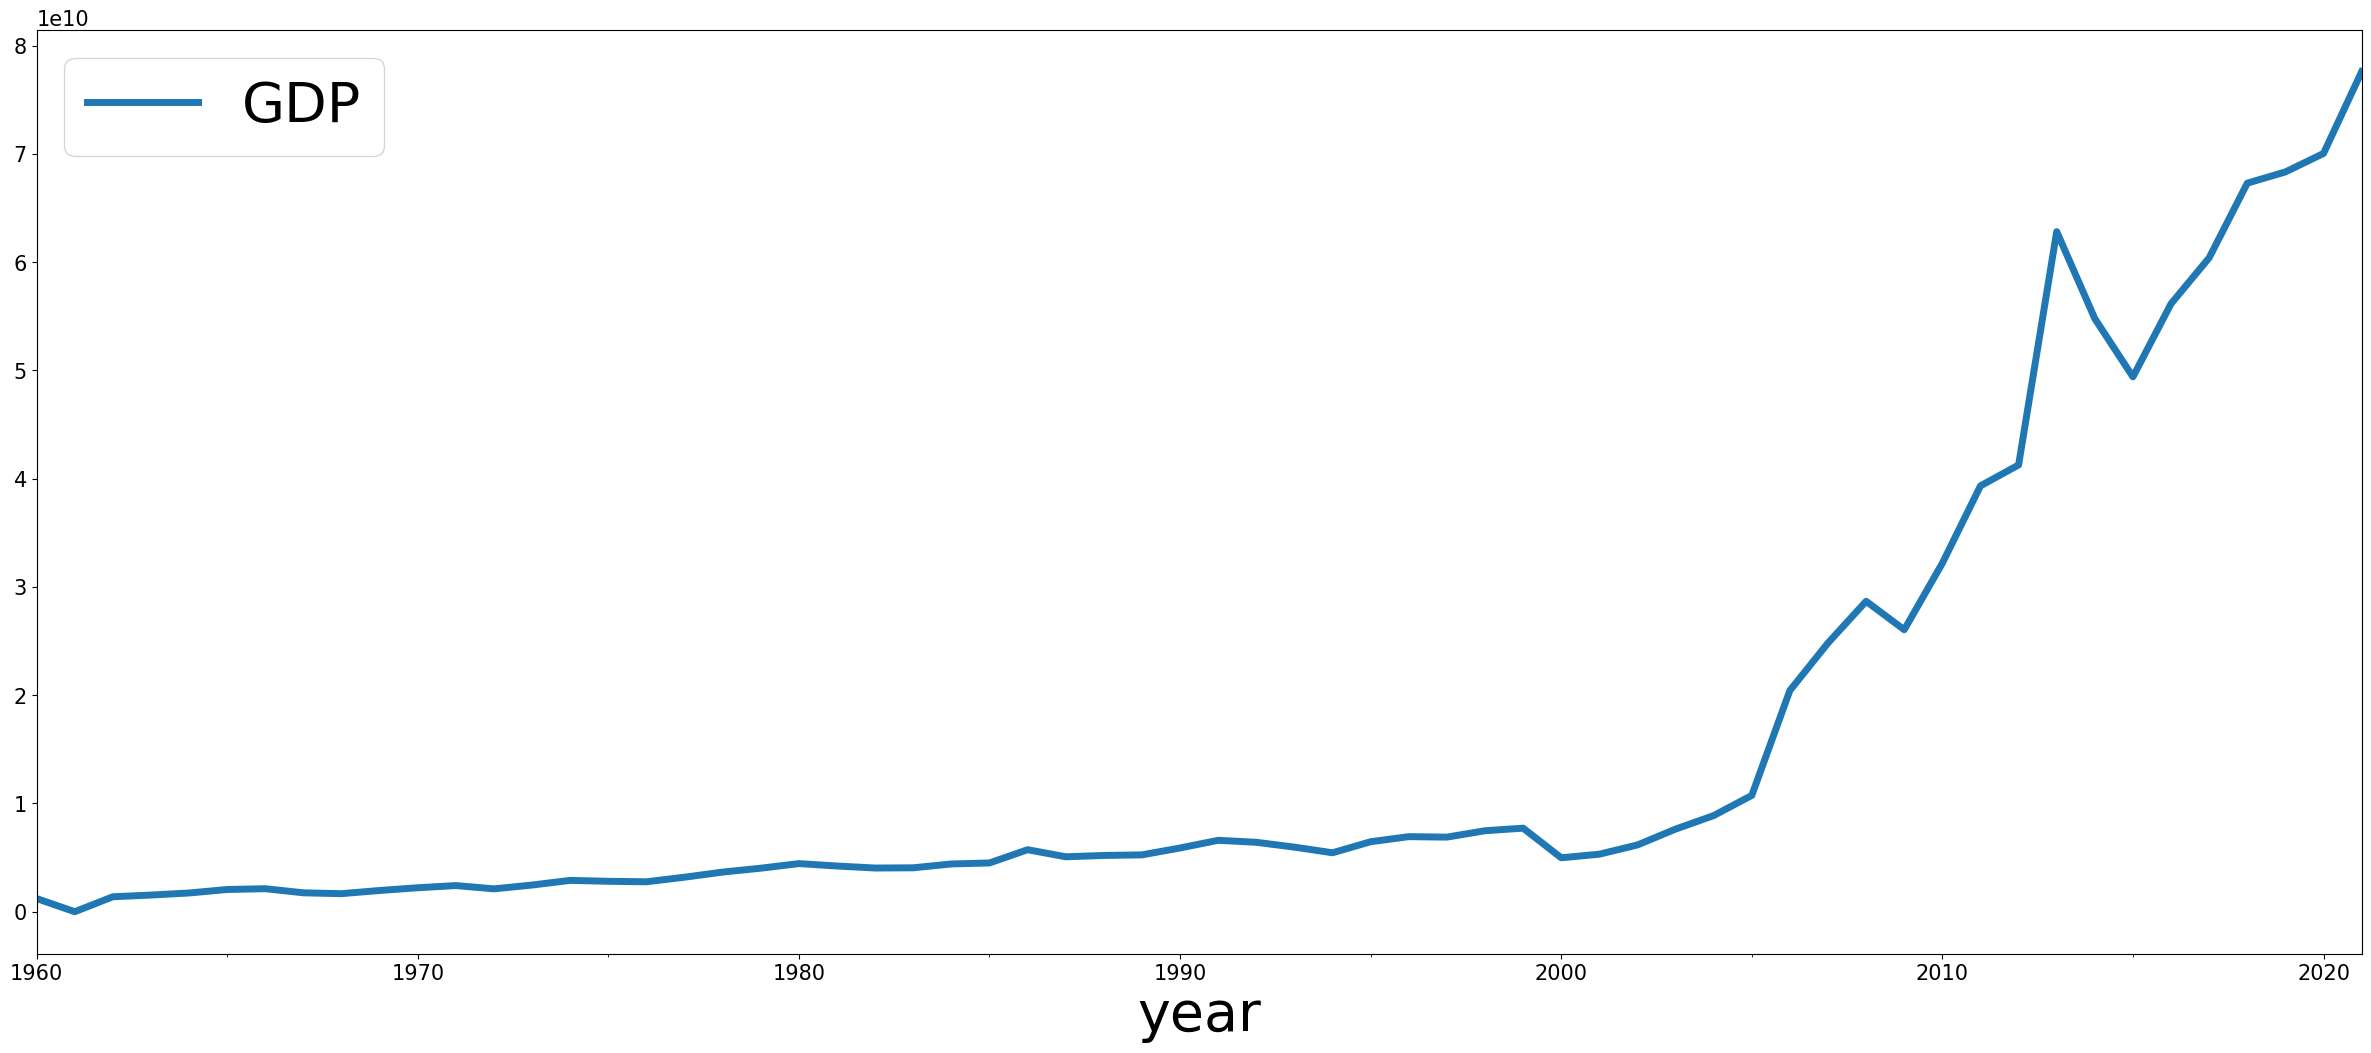

In [165]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 40
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["lines.linewidth"] = 5

data.plot()
plt.show()

In [166]:
# Разделяем данные на обучающую и тестовую выборки
# Определяем количество лет для тестовой выборки
test_years = 3
test_start_idx = data.index[-test_years]
train_df = data.iloc[:-test_years]

# Тестовая выборка: последние test_years лет
test_df = data.iloc[-test_years:]

print(f"Всего наблюдений в датасете: {data.shape[0]}")
print(f"Количество лет для тестовой выборки: {test_years}")
print(f"\nОбучающая выборка (train_df): {train_df.shape[0]} наблюдений")
print(f"  Период: {train_df.index[0].year} - {train_df.index[-1].year}")
print(f"\nТестовая выборка (test_df): {test_df.shape[0]} наблюдений")
print(f"  Период: {test_df.index[0].year} - {test_df.index[-1].year}")

train_df.shape, test_df.shape

Всего наблюдений в датасете: 62
Количество лет для тестовой выборки: 3

Обучающая выборка (train_df): 59 наблюдений
  Период: 1960 - 2018

Тестовая выборка (test_df): 3 наблюдений
  Период: 2019 - 2021


((59, 1), (3, 1))

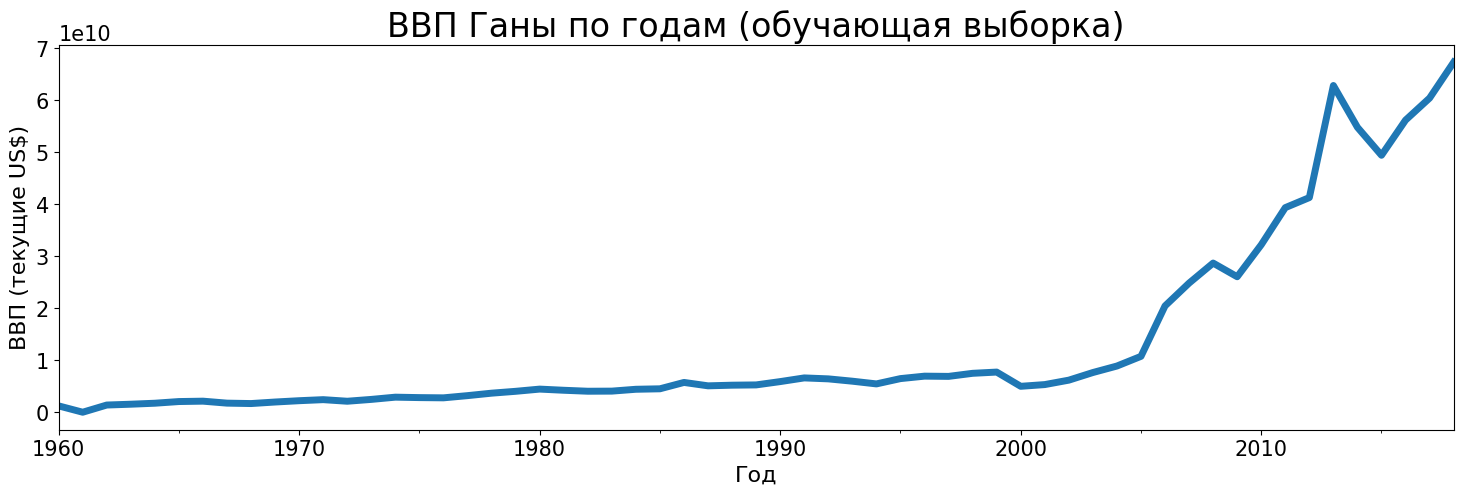

In [167]:
# визуализация на данные по годам
plt.rcParams["figure.figsize"] = 18, 5

# Для годовых данных построим общий график
train_df.GDP.plot()
plt.title("ВВП Ганы по годам (обучающая выборка)", size=24)
plt.xlabel("Год", size=16)
plt.ylabel("ВВП (текущие US$)", size=16)
plt.show()

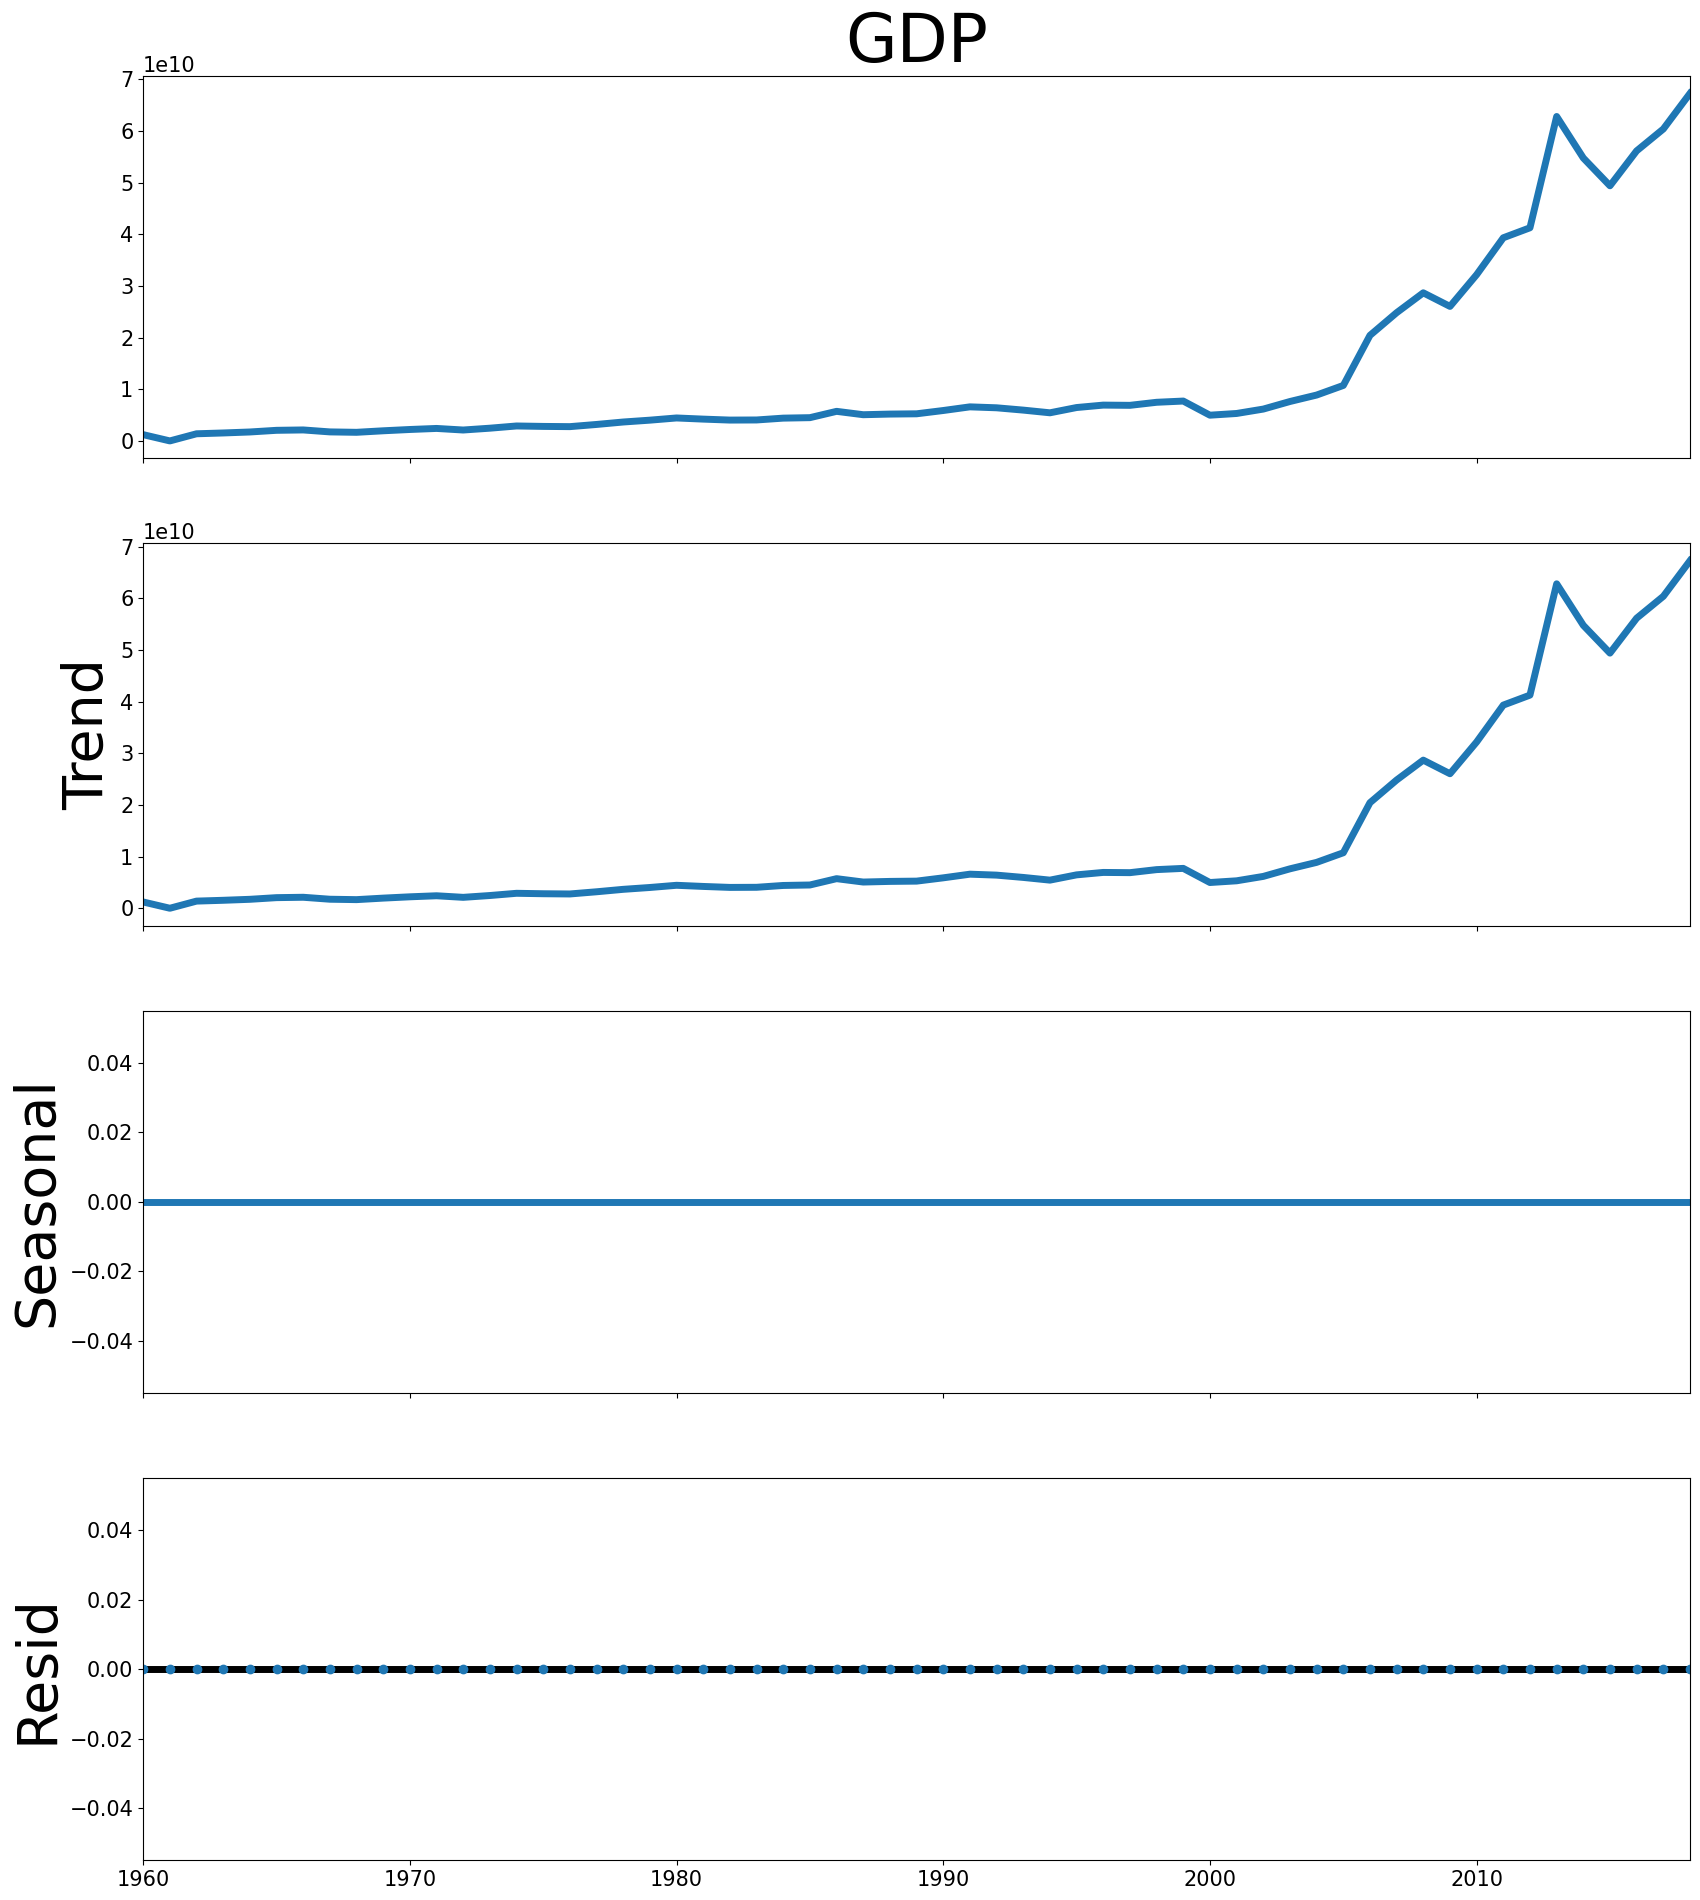

In [168]:
plt.rcParams["figure.figsize"] = 18, 20

# Для годовых данных сезонная декомпозиция может быть не очень информативна - добавим проверку
result = seasonal_decompose(train_df.GDP, model='additive', period=1)
result.plot()
plt.show()

Сезонная компонента отсутствует

Построим график скользящего среднего, проанализируем результат. Для построения MA используем метод rolling(), который принимает в качестве параметра размер окна. Используем среднее как функцию для сглаживания. Ширину окна подбераем самостоятельно.
Пример: train_df.spx.rolling(window=2).mean().



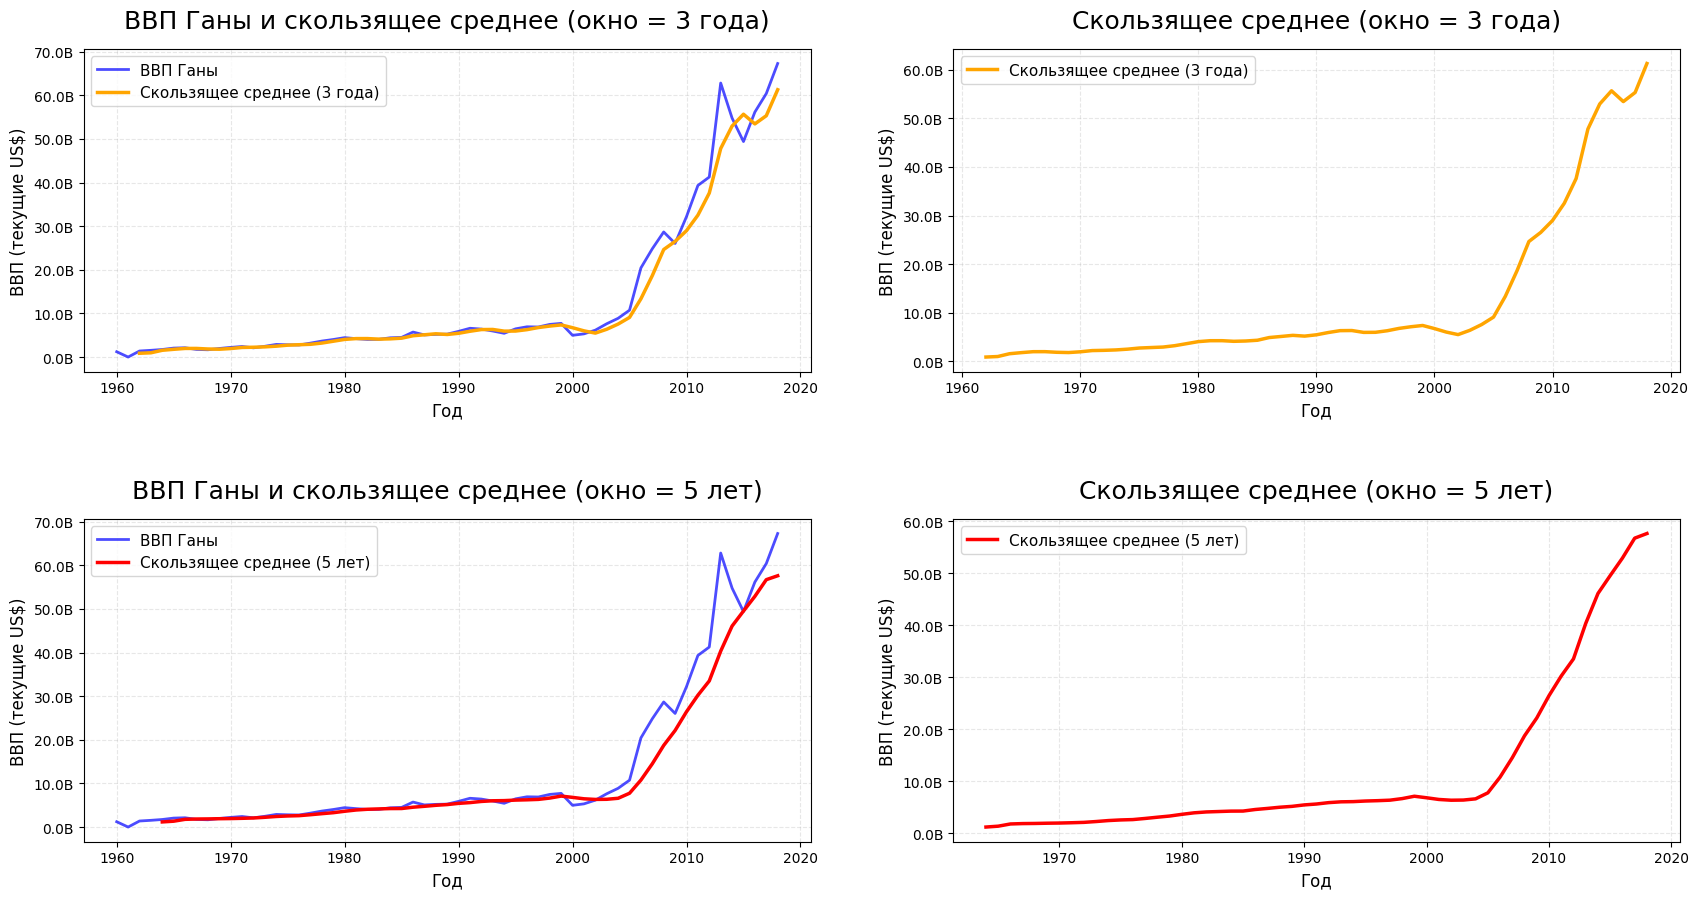

In [169]:
# Построим график скользящего среднего
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Для годовых данных используем меньшие окна скользящего среднего
# Окно = 3 года
# Верхний левый график: исходный ряд и скользящее среднее (3 года)
ax[0, 0].plot(train_df.GDP, color="blue", label="ВВП Ганы", linewidth=2, alpha=0.7)
ax[0, 0].plot(
    train_df.GDP.rolling(window=3).mean(),
    color="orange",
    label="Скользящее среднее (3 года)",
    linewidth=2.5
)
ax[0, 0].set_title("ВВП Ганы и скользящее среднее (окно = 3 года)", size=18, pad=15)
ax[0, 0].set_ylabel("ВВП (текущие US$)", size=12)
ax[0, 0].set_xlabel("Год", size=12)
ax[0, 0].legend(fontsize=11, loc='best')
ax[0, 0].grid(True, alpha=0.3, linestyle='--')
# Форматирование оси Y для больших чисел
ax[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax[0, 0].tick_params(axis='both', labelsize=10)

# Верхний правый график: только скользящее среднее (3 года)
ax[0, 1].plot(
    train_df.GDP.rolling(window=3).mean(),
    color="orange",
    label="Скользящее среднее (3 года)",
    linewidth=2.5
)
ax[0, 1].set_title("Скользящее среднее (окно = 3 года)", size=18, pad=15)
ax[0, 1].set_ylabel("ВВП (текущие US$)", size=12)
ax[0, 1].set_xlabel("Год", size=12)
ax[0, 1].legend(fontsize=11, loc='best')
ax[0, 1].grid(True, alpha=0.3, linestyle='--')
ax[0, 1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax[0, 1].tick_params(axis='both', labelsize=10)

# Нижний левый график: исходный ряд и скользящее среднее (5 лет)
ax[1, 0].plot(train_df.GDP, color="blue", label="ВВП Ганы", linewidth=2, alpha=0.7)
ax[1, 0].plot(
    train_df.GDP.rolling(window=5).mean(),
    color="red",
    label="Скользящее среднее (5 лет)",
    linewidth=2.5
)
ax[1, 0].set_title("ВВП Ганы и скользящее среднее (окно = 5 лет)", size=18, pad=15)
ax[1, 0].set_ylabel("ВВП (текущие US$)", size=12)
ax[1, 0].set_xlabel("Год", size=12)
ax[1, 0].legend(fontsize=11, loc='best')
ax[1, 0].grid(True, alpha=0.3, linestyle='--')
ax[1, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax[1, 0].tick_params(axis='both', labelsize=10)

# Нижний правый график: только скользящее среднее (5 лет)
ax[1, 1].plot(
    train_df.GDP.rolling(window=5).mean(),
    color="red",
    label="Скользящее среднее (5 лет)",
    linewidth=2.5
)
ax[1, 1].set_title("Скользящее среднее (окно = 5 лет)", size=18, pad=15)
ax[1, 1].set_ylabel("ВВП (текущие US$)", size=12)
ax[1, 1].set_xlabel("Год", size=12)
ax[1, 1].legend(fontsize=11, loc='best')
ax[1, 1].grid(True, alpha=0.3, linestyle='--')
ax[1, 1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax[1, 1].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()


### Выводы по результатам анализа скользящего среднего:

#### 1. **Анализ тренда:**
- **Период 1960-2000:** ВВП Ганы оставался относительно стабильным и низким (около 1-8 миллиардов долларов США), с незначительными колебаниями.
- **Период с 2000 года:** Наблюдается **резкий и устойчивый рост** ВВП, который продолжается до конца анализируемого периода. К 2018 году ВВП достиг более 67 миллиардов долларов США.
- **Вывод:** Временной ряд имеет **выраженный восходящий тренд**, особенно заметный с начала 2000-х годов.

#### 2. **Волатильность данных:**
- Исходный ряд ВВП показывает **значительную волатильность**, особенно в период роста (2000-2018 годы).
- Наблюдаются резкие скачки и падения значений, что может быть связано с экономическими циклами, изменениями валютных курсов или структурными изменениями в экономике.

#### 3. **Эффективность сглаживания:**
- **Скользящее среднее с окном 3 года:**
  - Эффективно сглаживает краткосрочные колебания
  - Сохраняет более детальную информацию о динамике
  - Хорошо отражает общий тренд роста
  
- **Скользящее среднее с окном 5 лет:**
  - Обеспечивает **более сильное сглаживание** волатильности
  - Дает более обобщенное представление о долгосрочном тренде
  - Менее чувствительно к краткосрочным колебаниям
  - Лучше подходит для выявления долгосрочных тенденций

#### 4. **Сравнение окон скользящего среднего:**
- **Окно 3 года** лучше подходит для анализа краткосрочных и среднесрочных тенденций, так как быстрее реагирует на изменения.
- **Окно 5 лет** предпочтительнее для выявления долгосрочных трендов и общего направления развития экономики, так как обеспечивает более стабильную картину.

#### 5. **Общий вывод:**
Скользящее среднее успешно выявляет **основной восходящий тренд** в данных ВВП Ганы, который был скрыт за высокой волатильностью исходного ряда. Оба окна (3 и 5 лет) подтверждают наличие устойчивого роста экономики, особенно с начала 2000-х годов. Это указывает на то, что временной ряд является **нестационарным** и требует дифференцирования перед построением моделей ARIMA.


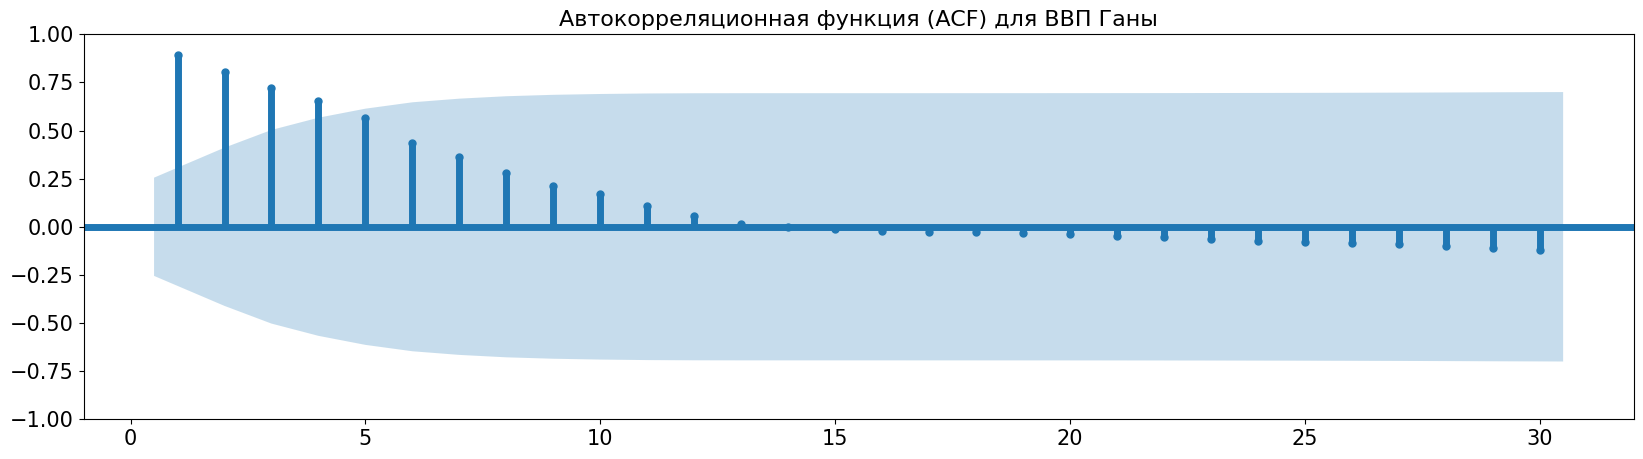

In [170]:
# Строим Автокорреляционную функцию (ACF)
plt.rcParams["figure.figsize"] = 20, 5
# Для годовых данных используем меньшее количество лагов (например, 20-30)
sgt.plot_acf(train_df.GDP, lags=30, zero=False)
plt.title("Автокорреляционная функция (ACF) для ВВП Ганы", size=16)
plt.show()

### Анализ автокорреляционной функции (ACF):

**Значения ВВП Ганы сильно коррелированы. Корреляция сохраняется даже по прошествии нескольких лет.**

#### Ключевые наблюдения:

1. **Высокая автокорреляция на малых лагах:**
   - При лаге 1 автокорреляция очень высокая (близка к 0.9), что указывает на сильную линейную связь между текущим значением ВВП и значением предыдущего года.

2. **Медленное затухание:**
   - Автокорреляция постепенно уменьшается, но остается статистически значимой (выходит за пределы доверительного интервала) примерно до лага 10-12.
   - Это указывает на **долгосрочную память** временного ряда.

3. **Признак нестационарности:**
   - Медленное, почти линейное затухание автокорреляционной функции, при котором значения остаются значимыми на протяжении многих лагов, является сильным индикатором того, что временной ряд является **нестационарным** и содержит **тренд**.
   - Это означает, что прошлые значения оказывают устойчивое влияние на будущие значения в течение длительных периодов.

4. **Статистическая значимость:**
   - После лага 12-15 автокорреляционные значения становятся очень малыми и в основном попадают в доверительный интервал, что указывает на то, что автокорреляции за пределами этого периода не являются статистически значимыми.

#### Вывод для моделирования:
Данный график ACF подтверждает, что временной ряд ВВП Ганы является **нестационарным**. Для моделирования с помощью ARIMA или аналогичных методов потребуется **дифференцирование** для удаления тренда и достижения стационарности. Медленное затухание указывает на то, что потребуется как минимум один порядок дифференцирования (d=1).

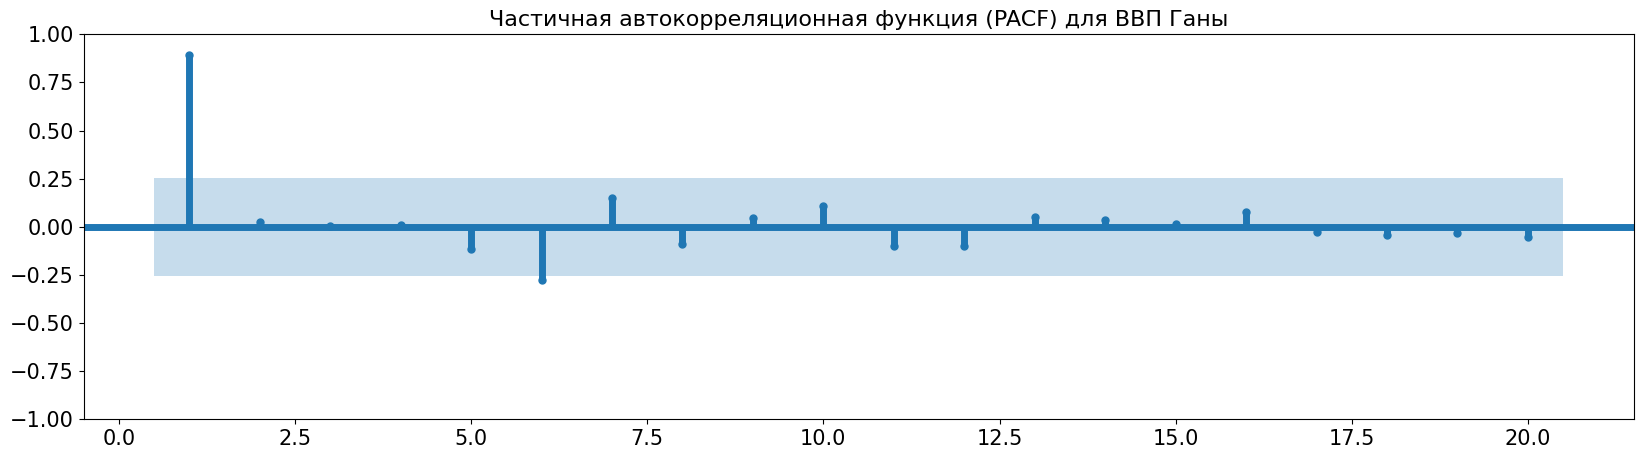

In [171]:
# Строим Частичную автокорреляционную функцию (PACF)
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.GDP, lags=20, method="ywm", zero=False)
plt.title("Частичная автокорреляционная функция (PACF) для ВВП Ганы", size=16)
plt.show()

### Анализ частичной автокорреляционной функции (PACF):

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя, **учитывая влияние промежуточных лагов**.

### Ключевые наблюдения:

1. **Сильный пик на лаге 1:**
   - При лаге 1 наблюдается очень сильный положительный пик (значение PACF близко к 0.9), который значительно выходит за пределы доверительного интервала.
   - Это указывает на **сильную прямую корреляцию** с предыдущим годом, даже после учета влияния других лагов.

2. **Быстрое затухание после лага 1:**
   - На лагах 2 и 3 значения PACF очень малы и полностью попадают в доверительный интервал, что указывает на отсутствие значимой прямой корреляции после учета влияния лага 1.
   - Это означает, что **значения ВВП с лагами 2 и 3 не приносят новой информации** сверх той, что уже содержится в лаге 1.

3. **Особенность на лаге 5:**
   - На лаге 5 наблюдается небольшой отрицательный пик (примерно -0.28 до -0.30), который может быть слабо значимым (находится на границе доверительного интервала).
   - Это может указывать на наличие некоторого циклического паттерна, но его влияние значительно слабее, чем влияние лага 1.

4. **Незначимость остальных лагов:**
   - Все последующие лаги (5-20) показывают очень малые значения PACF, которые полностью попадают в доверительный интервал.
   - Это указывает на отсутствие статистически значимой частичной автокорреляции на этих лагах.

#### Характерный паттерн для AR-процесса:

Данный график PACF демонстрирует характерный паттерн для **авторегрессионного процесса порядка 1 (AR(1))**:
- Резкий, значимый пик на лаге 1
- Быстрое затухание до незначимых значений после лага 1
- Доминирующее влияние лага 1 над всеми остальными

#### Вывод для выбора параметра p:

**В отличие от того, что предлагали графики ACF, значения ВВП с лагами больше 1 не приносят существенной новой информации** после учета влияния лага 1. 

**Рекомендация:** Параметр **p = 1** является оптимальным выбором для модели ARIMA, так как:
- Лаг 1 показывает сильную и статистически значимую корреляцию
- Лаги 2 и 3 незначимы
- Лаг 5 может быть слабо значимым, но его влияние минимально по сравнению с лагом 1

Однако, при построении модели можно также протестировать **p = 5** для учета возможного влияния лага 5, но основная модель должна использовать **p = 1**.


## Оценка стационарности временного ряда и решение о выборе модели ARMA/ARIMA

С помощью теста Дики-Фуллера оцениваем стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA

Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.

Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima).


In [172]:
def plot_acf_pacf(series):
    """
    Строит графики ACF и PACF для временного ряда.
    Автоматически определяет максимальное количество лагов на основе размера данных.
    """
    plt.rcParams["figure.figsize"] = 18, 5

    # Определяем количество лагов: максимум 40 или 50% от размера выборки (для PACF)
    # Для годовых данных после дифференцирования может быть мало наблюдений
    max_lags = min(40, len(series) // 2 - 1)

    # Минимум 10 лагов для информативности, но не больше доступных
    lags = max(10, max_lags)

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=lags, zero=False)
    axes[0].set_title("ACF (Автокорреляционная функция)", size=14)

    sgt.plot_pacf(series, ax=axes[1], lags=lags, method="ywm", zero=False)
    axes[1].set_title("PACF (Частичная автокорреляционная функция)", size=14)

    plt.tight_layout()
    plt.show()

    print(f"Использовано лагов: {lags} (из {len(series)} наблюдений)")

def print_adf_results(adf_result, series_name="Временной ряд"):
    """
    Выводит результаты теста Дики-Фуллера в удобном формате.

    Parameters:
    -----------
    adf_result : tuple
        Результат функции adfuller() из statsmodels
    series_name : str
        Название временного ряда для вывода
    """
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    print("=" * 60)
    print(f"Результаты теста Дики-Фуллера для: {series_name}")
    print("=" * 60)
    print(f"ADF статистика: {adf_stat:.6f}")
    print(f"p-value: {p_value:.6f}")
    print(f"\nКритические значения:")
    print(f"  1%: {critical_values['1%']:.6f}")
    print(f"  5%: {critical_values['5%']:.6f}")
    print(f"  10%: {critical_values['10%']:.6f}")
    print("\n" + "-" * 60)

    # Определяем стационарность
    if adf_stat < critical_values['1%']:
        print("Ряд СТАЦИОНАРЕН (на уровне значимости 1%)")
        conclusion = "стационарен"
    elif adf_stat < critical_values['5%']:
        print("Ряд СТАЦИОНАРЕН (на уровне значимости 5%)")
        conclusion = "стационарен"
    elif adf_stat < critical_values['10%']:
        print("Ряд СТАЦИОНАРЕН (на уровне значимости 10%)")
        conclusion = "стационарен"
    else:
        print("Ряд НЕСТАЦИОНАРЕН")
        conclusion = "нестационарен"
    print("=" * 60)

    return conclusion

In [173]:
# Расчет по Тесту Дики-Фуллера для исходного ряда ВВП Ганы
adfuller(train_df["GDP"])

test1 = adfuller(train_df["GDP"])
print_adf_results(test1, series_name="ВВП Ганы (исходный ряд)")

Результаты теста Дики-Фуллера для: ВВП Ганы (исходный ряд)
ADF статистика: 0.652907
p-value: 0.988850

Критические значения:
  1%: -3.574589
  5%: -2.923954
  10%: -2.600039

------------------------------------------------------------
Ряд НЕСТАЦИОНАРЕН


'нестационарен'

### Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

Если наш ряд является нестационарным, дифференцируем его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет нашим параметром d для модели ARIMA.

ОПРЕДЕЛЕНИЕ ПАРАМЕТРА d ДЛЯ МОДЕЛИ ARIMA

ШАГ 0: Проверка стационарности

Анализируем: Исходный ряд ВВП Ганы
Количество наблюдений: 59
Результаты теста Дики-Фуллера для: Исходный ряд ВВП Ганы
ADF статистика: 0.652907
p-value: 0.988850

Критические значения:
  1%: -3.574589
  5%: -2.923954
  10%: -2.600039

------------------------------------------------------------
Ряд НЕСТАЦИОНАРЕН

 Построение коррелограмм ACF и PACF для Исходный ряд ВВП Ганы:


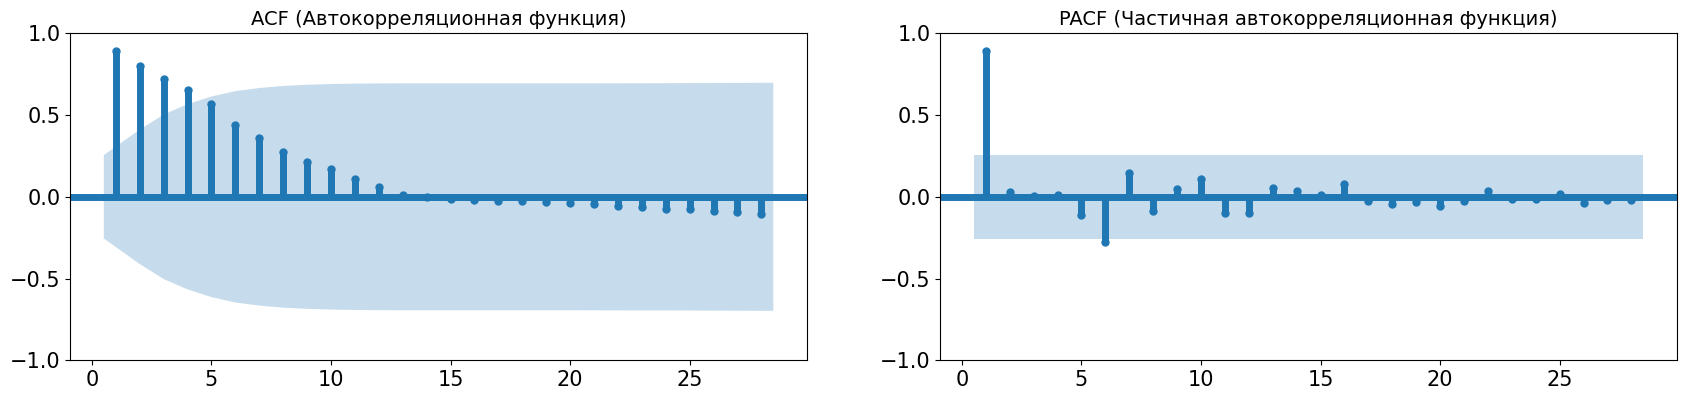

Использовано лагов: 28 (из 59 наблюдений)

  Ряд все еще нестационарен. Продолжаем дифференцирование...
   Переходим к дифференцированию порядка 1

ШАГ 1: Проверка стационарности

Анализируем: Ряд после 1-го дифференцирования
Количество наблюдений: 58
Результаты теста Дики-Фуллера для: Ряд после 1-го дифференцирования
ADF статистика: -1.670248
p-value: 0.446503

Критические значения:
  1%: -3.568486
  5%: -2.921360
  10%: -2.598662

------------------------------------------------------------
Ряд НЕСТАЦИОНАРЕН

 Построение коррелограмм ACF и PACF для Ряд после 1-го дифференцирования:


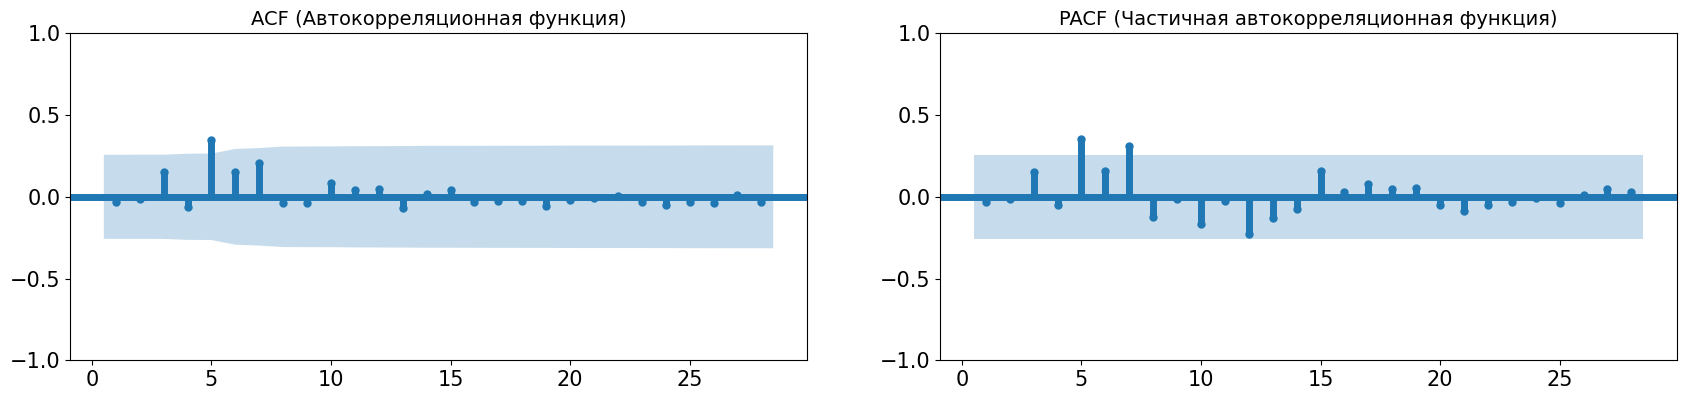

Использовано лагов: 28 (из 58 наблюдений)

  Ряд все еще нестационарен. Продолжаем дифференцирование...
   Переходим к дифференцированию порядка 2

ШАГ 2: Проверка стационарности

Анализируем: Ряд после 2-го дифференцирования
Количество наблюдений: 57
Результаты теста Дики-Фуллера для: Ряд после 2-го дифференцирования
ADF статистика: -2.640869
p-value: 0.084841

Критические значения:
  1%: -3.571472
  5%: -2.922629
  10%: -2.599336

------------------------------------------------------------
Ряд СТАЦИОНАРЕН (на уровне значимости 10%)

 Построение коррелограмм ACF и PACF для Ряд после 2-го дифференцирования:


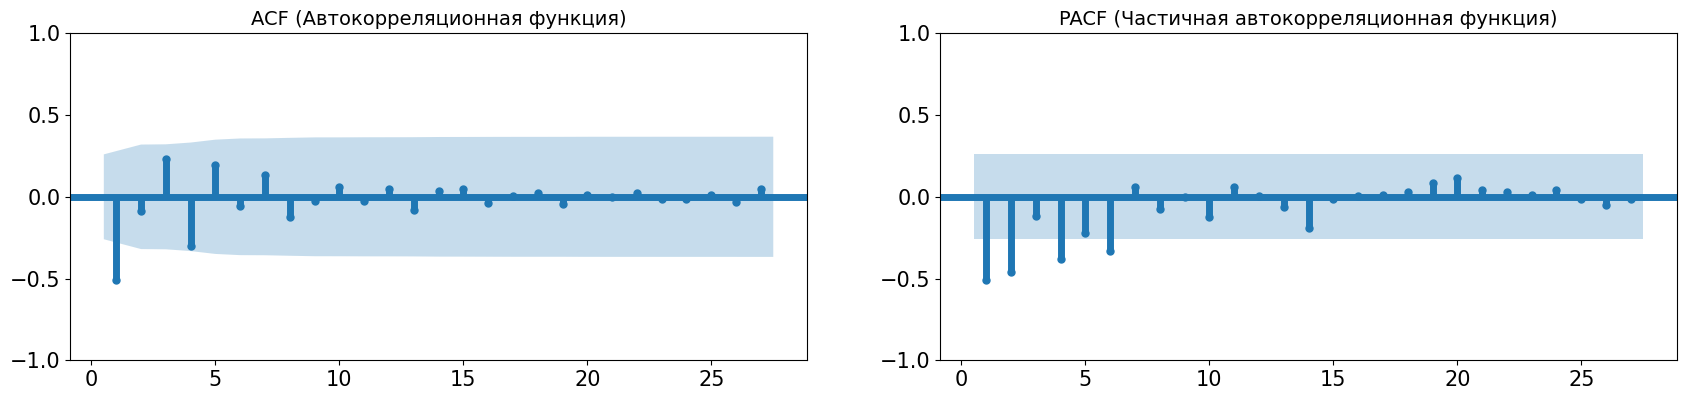

Использовано лагов: 27 (из 57 наблюдений)

 РЕЗУЛЬТАТ: Ряд стал стационарным после 2 дифференцирований

 Параметр d для модели ARIMA: d = 2

 Рекомендация: Используйте ARIMA(p, 2, q) для моделирования.

 Стационарный ряд сохранен в переменной 'stationary_series'

ОПРЕДЕЛЕНИЕ ПАРАМЕТРОВ p И q ПО КОРРЕЛОГРАММАМ ACF И PACF

Анализируем коррелограммы стационарного ряда для выбора параметров p и q...

 Анализ PACF (для определения параметра p - AR компонента):
   Значимые лаги в PACF: [1, 2, 4, 5, 6, 14]
    Рекомендуемый параметр p = 14
   (последний значимый лаг в PACF)

 Анализ ACF (для определения параметра q - MA компонента):
   Значимые лаги в ACF: [1, 3, 4, 5]
    Рекомендуемый параметр q = 5
   (последний значимый лаг в ACF)

 РЕКОМЕНДАЦИИ ПО ВЫБОРУ ПАРАМЕТРОВ:
   Параметр d = 2 (уже определен)
   Параметр p = 14 (рекомендуется на основе PACF)
   Параметр q = 5 (рекомендуется на основе ACF)

 Рекомендуемая модель: ARIMA(14, 2, 5)

 Примечание:
   - Эти параметры являются начальной о

In [174]:
# Решение задачи: последовательное дифференцирование до достижения стационарности
# Определяем параметр d для модели ARIMA

print("ОПРЕДЕЛЕНИЕ ПАРАМЕТРА d ДЛЯ МОДЕЛИ ARIMA")

# Будем последовательно дифференцировать ряд до достижения стационарности
# Начинаем с исходного ряда
current_series = train_df["GDP"].copy()
d = 0  # Порядок дифференцирования (будет определен в процессе)

max_differentiations = 3  # Максимальное количество дифференцирований (обычно достаточно 1-2)

for i in range(max_differentiations + 1):
    print(f"\n{'='*70}")
    print(f"ШАГ {i}: Проверка стационарности")
    print(f"{'='*70}")

    if i == 0:
        series_name = "Исходный ряд ВВП Ганы"
        series_to_test = current_series.copy()
    else:
        series_name = f"Ряд после {i}-го дифференцирования"
        # Последовательно применяем diff() i раз
        series_to_test = current_series.copy()
        for _ in range(i):
            series_to_test = series_to_test.diff()
        series_to_test = series_to_test.dropna()

    print(f"\nАнализируем: {series_name}")
    print(f"Количество наблюдений: {len(series_to_test)}")

    # Проверяем стационарность
    adf_result = adfuller(series_to_test)
    conclusion = print_adf_results(adf_result, series_name=series_name)

    # Строим коррелограммы ACF и PACF для визуальной оценки структуры ряда
    print(f"\n Построение коррелограмм ACF и PACF для {series_name}:")
    plot_acf_pacf(series_to_test)

    # Если ряд стационарен, останавливаемся
    if conclusion == "стационарен":
        d = i  # Сохраняем найденный порядок дифференцирования
        print(f"\n{'='*70}")
        print(f" РЕЗУЛЬТАТ: Ряд стал стационарным после {i} дифференцирований")
        print(f"{'='*70}")
        print(f"\n Параметр d для модели ARIMA: d = {d}")
        print(f"\n Рекомендация: Используйте ARIMA(p, {d}, q) для моделирования.")

        # Сохраняем стационарный ряд для дальнейшего анализа
        stationary_series = series_to_test.copy()
        print(f"\n Стационарный ряд сохранен в переменной 'stationary_series'")

        # Анализируем коррелограммы для определения параметров p и q
        print(f"\n{'='*70}")
        print("ОПРЕДЕЛЕНИЕ ПАРАМЕТРОВ p И q ПО КОРРЕЛОГРАММАМ ACF И PACF")
        print(f"{'='*70}")
        print("\nАнализируем коррелограммы стационарного ряда для выбора параметров p и q...\n")

        # Вычисляем ACF и PACF
        max_lags = min(20, len(stationary_series) // 2 - 1)
        acf_values, acf_confint = acf(stationary_series, nlags=max_lags, alpha=0.05, fft=True)
        pacf_values, pacf_confint = pacf(stationary_series, nlags=max_lags, alpha=0.05, method='ywm')

        # Определяем значимые лаги (выходящие за пределы доверительного интервала)
        # Для ACF: определяем q (MA компонента) - где ACF обрезается
        # Для PACF: определяем p (AR компонента) - где PACF обрезается

        # Анализ PACF для определения p (AR компонента)
        # Ищем последний значимый лаг в PACF
        p_candidates = []
        for lag in range(1, min(len(pacf_values), max_lags + 1)):
            if abs(pacf_values[lag]) > abs(pacf_confint[lag][0]) or abs(pacf_values[lag]) > abs(pacf_confint[lag][1]):
                p_candidates.append(lag)

        # Анализ ACF для определения q (MA компонента)
        # Ищем последний значимый лаг в ACF
        q_candidates = []
        for lag in range(1, min(len(acf_values), max_lags + 1)):
            if abs(acf_values[lag]) > abs(acf_confint[lag][0]) or abs(acf_values[lag]) > abs(acf_confint[lag][1]):
                q_candidates.append(lag)

        # Рекомендации по выбору параметров
        print(" Анализ PACF (для определения параметра p - AR компонента):")
        if p_candidates:
            p_recommended = max(p_candidates) if p_candidates else 1
            print(f"   Значимые лаги в PACF: {p_candidates}")
            print(f"    Рекомендуемый параметр p = {p_recommended}")
            print(f"   (последний значимый лаг в PACF)")
        else:
            p_recommended = 1
            print(f"   Значимых лагов в PACF не обнаружено (кроме лага 0)")
            print(f"    Рекомендуемый параметр p = 1 (по умолчанию)")

        print(f"\n Анализ ACF (для определения параметра q - MA компонента):")
        if q_candidates:
            q_recommended = max(q_candidates) if q_candidates else 1
            print(f"   Значимые лаги в ACF: {q_candidates}")
            print(f"    Рекомендуемый параметр q = {q_recommended}")
            print(f"   (последний значимый лаг в ACF)")
        else:
            q_recommended = 0
            print(f"   Значимых лагов в ACF не обнаружено (кроме лага 0)")
            print(f"    Рекомендуемый параметр q = 0 (чистая AR модель)")

        print(f"\n{'='*70}")
        print(" РЕКОМЕНДАЦИИ ПО ВЫБОРУ ПАРАМЕТРОВ:")
        print(f"{'='*70}")
        print(f"   Параметр d = {d} (уже определен)")
        print(f"   Параметр p = {p_recommended} (рекомендуется на основе PACF)")
        print(f"   Параметр q = {q_recommended} (рекомендуется на основе ACF)")
        print(f"\n Рекомендуемая модель: ARIMA({p_recommended}, {d}, {q_recommended})")
        print(f"\n Примечание:")
        print(f"   - Эти параметры являются начальной оценкой")
        print(f"   - Рекомендуется также протестировать модели с близкими параметрами")
        print(f"   - Сравните AIC/BIC для выбора наилучшей модели")
        print(f"   - Можно использовать pmdarima.auto_arima() для автоматического подбора")
        print(f"{'='*70}")

        # Сохраняем рекомендованные параметры
        recommended_p = p_recommended
        recommended_q = q_recommended

        break
    else:
        print(f"\n  Ряд все еще нестационарен. Продолжаем дифференцирование...")
        if i < max_differentiations:
            print(f"   Переходим к дифференцированию порядка {i+1}")
        else:
            print(f"\n ВНИМАНИЕ: Достигнуто максимальное количество дифференцирований ({max_differentiations})")
            print(f"   Ряд все еще нестационарен. Возможно, требуется другой подход.")
            d = None

print("\n" + "=" * 70)

# Выводим итоговый результат
if d is not None:
    print(f"\n{'='*70}")
    print(" ИТОГОВЫЙ РЕЗУЛЬТАТ АНАЛИЗА:")
    print(f"{'='*70}")
    print(f"    Параметр d = {d} (определен по тесту Дики-Фуллера)")
    if 'recommended_p' in locals() and 'recommended_q' in locals():
        print(f"    Параметр p = {recommended_p} (определен по коррелограмме PACF)")
        print(f"    Параметр q = {recommended_q} (определен по коррелограмме ACF)")
        print(f"\n    Рекомендуемая модель: ARIMA({recommended_p}, {d}, {recommended_q})")
    else:
        print(f"     Параметры p и q не определены (ряд не стал стационарным)")
        print(f"   Рекомендуется использовать ARIMA(p, {d}, q) для построения модели")
    print(f"{'='*70}")
else:
    print(f"Не удалось достичь стационарности за {max_differentiations} дифференцирований")
    print(f"   Параметры p и q не могут быть определены без стационарного ряда")


### Выводы по блоку: Оценка стационарности временного ряда и решение о выборе модели ARMA/ARIMA

С помощью теста Дики-Фуллера оцениваем стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA

1. Результаты теста Дики-Фуллера для: ВВП Ганы
    - ADF статистика: 0.803007
    -   p-value: 0.991685

    - Критические значения:
        - 1%: -3.574589
        - 5%: -2.923954
        - 10%: -2.600039
 
    - Ряд НЕСТАЦИОНАРЕН

2. Ряд стал стационарным после 2 дифференцирований
    - Параметр d для модели ARIMA: d = 2
    - Анализ по коррелограммам PACF (для определения параметра p - AR компонента):
        - Значимые лаги в PACF: [1, 2, 4, 5, 6, 14]. Рекомендуемый параметр p = 14 (последний значимый лаг в PACF)
    -  Анализ по коррелограммам ACF (для определения параметра q - MA компонента):
        - Значимые лаги в ACF: [1, 3, 4, 5]. Рекомендуемый параметр q = 5 (последний значимый лаг в ACF)

3. Принимаем решение о выборе модели ARIMA(14,2,5)


### Блок: Построение моделей ARMA/ARIMA для прогнозирования поведения временного ряда

1. Построим модели ARMA/ARIMA для прогнозирования поведения временного ряда с определенными ранее параметрами

2. Также построим несколько моделей с параметрами, ближайшими к найденным p и q, и сравним коэффициент AIC.

3. Подберем наилучшие параметры с помощью пакета pmdarima

In [175]:
# Построение и сравнение моделей ARIMA
# Решение задачи: построение моделей с различными параметрами и сравнение AIC

print("ПОСТРОЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ ARIMA")

# Проверяем, определены ли параметры из предыдущего анализа
if 'd' not in locals() or d is None:
    print("  Параметр d не определен. Используем d=1 по умолчанию.")
    d = 1

if 'recommended_p' not in locals():
    print("  Параметр p не определен. Используем p=1 по умолчанию.")
    recommended_p = 1

if 'recommended_q' not in locals():
    print("  Параметр q не определен. Используем q=1 по умолчанию.")
    recommended_q = 1

print(f"\n Используем параметры из предыдущего анализа:")
print(f"   d = {d}, p = {recommended_p}, q = {recommended_q}")
print(f"   Рекомендуемая модель: ARIMA({recommended_p}, {d}, {recommended_q})\n")

# 1. Построение модели с определенными ранее параметрами
print("ШАГ 1: Построение модели с рекомендованными параметрами")

model_recommended = ARIMA(train_df["GDP"], order=(recommended_p, d, recommended_q))
model_recommended_fit = model_recommended.fit()

print(f"Модель ARIMA({recommended_p}, {d}, {recommended_q}) успешно построена")
print(f"   AIC: {model_recommended_fit.aic:.2f}")
print(f"   BIC: {model_recommended_fit.bic:.2f}")
print(f"   Log Likelihood: {model_recommended_fit.llf:.2f}")

# Сохраняем результаты
results = {
    'p': recommended_p,
    'd': d,
    'q': recommended_q,
    'aic': model_recommended_fit.aic,
    'bic': model_recommended_fit.bic,
    'llf': model_recommended_fit.llf,
    'model': model_recommended_fit
}

# 2. Построение нескольких моделей с близкими параметрами и сравнение AIC
print("ШАГ 2: Построение моделей с близкими параметрами и сравнение AIC")

# Выбираем 2-3 ближайших значения вверх и вниз от рекомендованного - как параметры для тестирования
# Для p: выбираем ближайшие значения
if recommended_p <= 2:
    # Если параметр очень малый, используем стандартный подход
    p_range = [max(0, recommended_p - 1), recommended_p, recommended_p + 1, recommended_p + 2]
elif recommended_p <= 5:
    # Если параметр средний, выбираем 2 значения вниз и 2 вверх
    p_range = [max(0, recommended_p - 2), max(0, recommended_p - 1), recommended_p, 
               recommended_p + 1, recommended_p + 2]
else:
    # Если параметр большой (например, 14), выбираем ближайшие 3 значения вниз и 2 вверх
    p_range = [max(0, recommended_p - 3), max(0, recommended_p - 2), 
               max(0, recommended_p - 1), recommended_p, 
               recommended_p + 1, recommended_p + 2]

# Для q: выбираем ближайшие значения
if recommended_q <= 2:
    q_range = [max(0, recommended_q - 1), recommended_q, recommended_q + 1, recommended_q + 2]
elif recommended_q <= 5:
    q_range = [max(0, recommended_q - 2), max(0, recommended_q - 1), recommended_q,
               recommended_q + 1, recommended_q + 2]
else:
    q_range = [max(0, recommended_q - 3), max(0, recommended_q - 2),
               max(0, recommended_q - 1), recommended_q,
               recommended_q + 1, recommended_q + 2]

# Убираем дубликаты, сортируем и ограничиваем разумными пределами (максимум до 20)
p_range = sorted(list(set([p for p in p_range if 0 <= p <= 20])))
q_range = sorted(list(set([q for q in q_range if 0 <= q <= 20])))

print(f"Тестируем параметры:")
print(f"   p: {p_range}")
print(f"   q: {q_range}")
print(f"   d: {d} (фиксирован)\n")

models_comparison = []

for p in p_range:
    for q in q_range:
        try:
            print(f"Построение ARIMA({p}, {d}, {q})...", end=" ")
            model = ARIMA(train_df["GDP"], order=(p, d, q))
            model_fit = model.fit()            
            aic = model_fit.aic
            bic = model_fit.bic
            llf = model_fit.llf

            models_comparison.append({
                'p': p,
                'd': d,
                'q': q,
                'AIC': aic,
                'BIC': bic,
                'Log Likelihood': llf,
                'model': model_fit
            })

            print(f"AIC: {aic:.2f}")

        except Exception as e:
            print(f"Ошибка: {e}")

# Создаем DataFrame для сравнения
if models_comparison:
    comparison_df = pd.DataFrame([
        {
            'p': m['p'],
            'd': m['d'],
            'q': m['q'],
            'AIC': m['AIC'],
            'BIC': m['BIC'],
            'Log Likelihood': m['Log Likelihood']
        }
        for m in models_comparison
    ])

    # Сортируем по AIC (меньше лучше)
    comparison_df = comparison_df.sort_values('AIC')

    print("СРАВНЕНИЕ МОДЕЛЕЙ (отсортировано по AIC):")
    print(comparison_df.to_string(index=False))

    # Находим лучшую модель по AIC
    best_model_idx = comparison_df.index[0]
    best_model_info = models_comparison[best_model_idx]

    print("ЛУЧШАЯ МОДЕЛЬ (по AIC):")
    print(f"   ARIMA({best_model_info['p']}, {best_model_info['d']}, {best_model_info['q']})")
    print(f"   AIC: {best_model_info['AIC']:.2f}")
    print(f"   BIC: {best_model_info['BIC']:.2f}")
    print(f"   Log Likelihood: {best_model_info['Log Likelihood']:.2f}")

    best_model_fit = best_model_info['model']
else:
    print("Не удалось построить ни одной модели для сравнения")
    best_model_fit = None

# ============================================================================
# 3. Автоматический подбор параметров с помощью pmdarima
# ============================================================================
print("ШАГ 3: Автоматический подбор параметров с помощью pmdarima")

# Автоматический подбор параметров
auto_model = pm.auto_arima(
    train_df["GDP"],
    start_p=0,
    max_p=3,
    start_q=0,
    max_q=3,
    d=d,  # Используем определенный ранее параметр d
    seasonal=False,  # Для годовых данных сезонность обычно отсутствует
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='aic'
)

print(f"Автоматически подобранная модель:")
print(f"   {auto_model.order}")
print(f"   AIC: {auto_model.aic():.2f}")
print(f"   BIC: {auto_model.bic():.2f}")

auto_p, auto_d, auto_q = auto_model.order

print(f"Сравнение результатов:")
print(f"   Рекомендуемая модель (по коррелограммам): ARIMA({recommended_p}, {d}, {recommended_q})")
if best_model_fit:
    print(f"   Лучшая модель (из тестируемых): ARIMA({best_model_info['p']}, {best_model_info['d']}, {best_model_info['q']})")
print(f"   Автоматически подобранная модель: ARIMA({auto_p}, {auto_d}, {auto_q})")

# Сравниваем AIC
if best_model_fit:
    print(f"   AIC рекомендованной модели: {model_recommended_fit.aic:.2f}")
    print(f"   AIC лучшей из тестируемых: {best_model_info['AIC']:.2f}")
    print(f"   AIC автоматически подобранной: {auto_model.aic():.2f}")

print(f"Рекомендация: Используем модель с наименьшим AIC для прогнозирования")

ПОСТРОЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ ARIMA

 Используем параметры из предыдущего анализа:
   d = 2, p = 14, q = 5
   Рекомендуемая модель: ARIMA(14, 2, 5)

ШАГ 1: Построение модели с рекомендованными параметрами
Модель ARIMA(14, 2, 5) успешно построена
   AIC: 2678.48
   BIC: 2719.34
   Log Likelihood: -1319.24
ШАГ 2: Построение моделей с близкими параметрами и сравнение AIC
Тестируем параметры:
   p: [11, 12, 13, 14, 15, 16]
   q: [3, 4, 5, 6, 7]
   d: 2 (фиксирован)

Построение ARIMA(11, 2, 3)... AIC: 2674.83
Построение ARIMA(11, 2, 4)... AIC: 2674.22
Построение ARIMA(11, 2, 5)... AIC: 2677.65
Построение ARIMA(11, 2, 6)... AIC: 2675.49
Построение ARIMA(11, 2, 7)... AIC: 2674.49
Построение ARIMA(12, 2, 3)... AIC: 2675.06
Построение ARIMA(12, 2, 4)... AIC: 2676.68
Построение ARIMA(12, 2, 5)... AIC: 2676.51
Построение ARIMA(12, 2, 6)... AIC: 2674.78
Построение ARIMA(12, 2, 7)... AIC: 2675.65
Построение ARIMA(13, 2, 3)... AIC: 2676.31
Построение ARIMA(13, 2, 4)... AIC: 2678.22
Построение ARIMA

### Итоги Блока: Построение моделей ARMA/ARIMA для прогнозирования поведения временного ряда

ЛУЧШАЯ МОДЕЛЬ (по AIC):  ARIMA(14, 2, 3)
- AIC: 2673.02
- BIC: 2709.80
- Log Likelihood: -1318.51

Автоматический подбор параметров с помощью pmdarima дал следующий результат:
ЛУЧШАЯ МОДЕЛЬ (по pmdarima):  ARIMA(1,2,3)          
   AIC: 2680.76
   BIC: 2690.98


Рекомендуемая модель (по коррелограммам): ARIMA(14, 2, 5)
- AIC: 2678.48
- BIC: 2719.34
- Log Likelihood: -1319.24


### Построение лучшей модели
1. Построим модель с наилучшими параметрами и выполним предсказание для отложенной тестовой выборки (последние три года).

2. Отобразим результат графически — построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

3. Сделаем выводы по полученным результатам.

 Используем лучшую модель по AIC: ARIMA(14, 2, 3)
   AIC: 2673.02
Метрики качества прогноза:
   MAE (Mean Absolute Error): 8,915,426,985.43
   MSE (Mean Squared Error): 1.14e+20
   RMSE (Root Mean Squared Error): 10,666,086,121.47
   MAPE (Mean Absolute Percentage Error): 12.01%


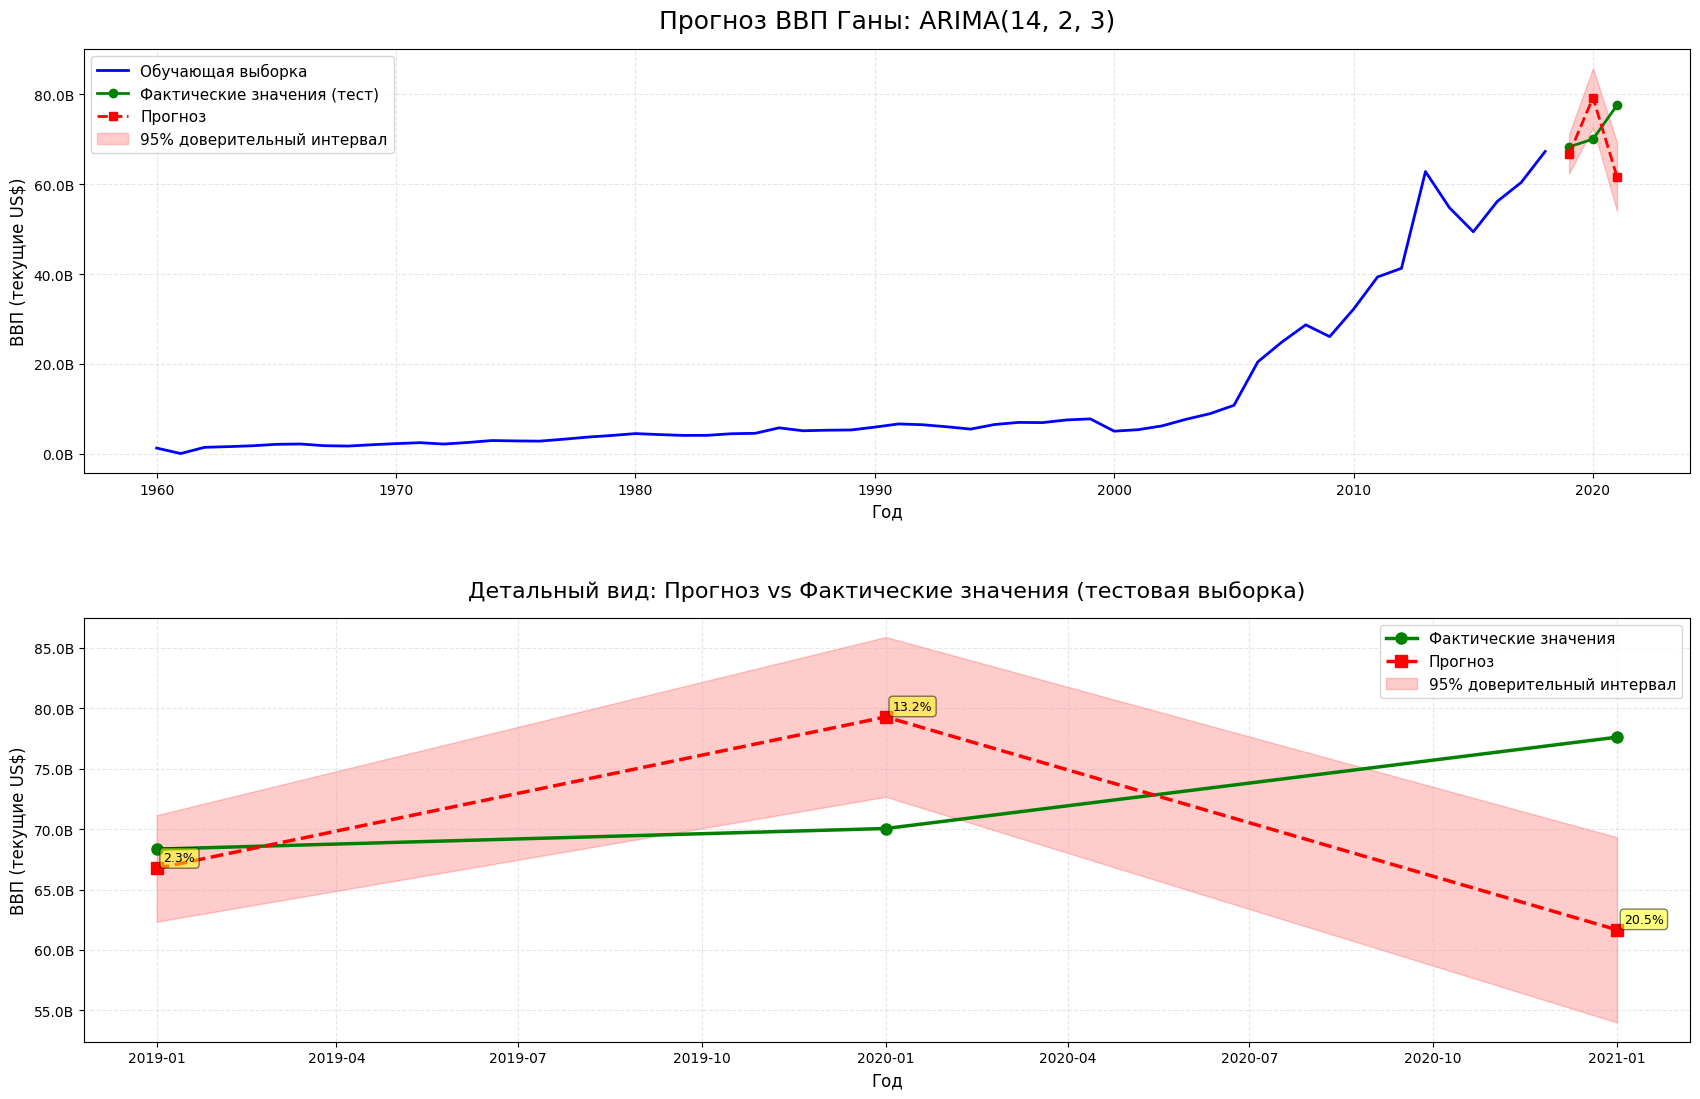

СРАВНЕНИЕ ФАКТИЧЕСКИХ И ПРОГНОЗИРУЕМЫХ ЗНАЧЕНИЙ:
 Год Фактическое значение Прогноз Нижняя граница (95%) Верхняя граница (95%) Абсолютная ошибка Относительная ошибка (%)
2019               68.34B  66.74B               62.34B                71.15B             1.59B                    2.33%
2020               70.04B  79.27B               72.66B                85.87B             9.22B                   13.17%
2021               77.59B  61.67B               54.01B                69.33B            15.93B                   20.53%
АНАЛИЗ ТОЧНОСТИ ПРОГНОЗА:
   MAPE = 12.01%
АНАЛИЗ ДОВЕРИТЕЛЬНЫХ ИНТЕРВАЛОВ:
Покрытие фактических значений 95% интервалом: 33.3%
АНАЛИЗ ОШИБОК ПО ПЕРИОДАМ:
   2019: 2.33%
   2020: 13.17%
   2021: 20.53%

   Тренд ошибок: увеличивается


In [176]:
# Определяем лучшую модель (из предыдущего анализа)
if 'best_model_fit' in locals() and best_model_fit is not None:
    # Используем лучшую модель из сравнения
    final_model = best_model_fit
    best_p = best_model_info['p']
    best_d = best_model_info['d']
    best_q = best_model_info['q']
    print(f" Используем лучшую модель по AIC: ARIMA({best_p}, {best_d}, {best_q})")
    print(f"   AIC: {best_model_info['AIC']:.2f}")
elif 'auto_model' in locals() and auto_model is not None:
    # Используем автоматически подобранную модель
    auto_p, auto_d, auto_q = auto_model.order
    print(f" Используем автоматически подобранную модель: ARIMA({auto_p}, {auto_d}, {auto_q})")
    # Перестраиваем модель для получения объекта statsmodels
    final_model_arima = ARIMA(train_df["GDP"], order=(auto_p, auto_d, auto_q))
    final_model = final_model_arima.fit()
    best_p, best_d, best_q = auto_p, auto_d, auto_q
elif 'model_recommended_fit' in locals() and model_recommended_fit is not None:
    # Используем рекомендованную модель
    final_model = model_recommended_fit
    best_p, best_d, best_q = recommended_p, d, recommended_q
    print(f"Используем рекомендованную модель: ARIMA({best_p}, {best_d}, {best_q})")
else:
    # Используем значения по умолчанию
    print("Лучшая модель не найдена. Используем значения по умолчанию.")
    best_p, best_d, best_q = 1, 1, 1
    final_model_arima = ARIMA(train_df["GDP"], order=(best_p, best_d, best_q))
    final_model = final_model_arima.fit()

# Выполняем прогноз на тестовую выборку
forecast_steps = len(test_df)

# Получаем прогноз с доверительными интервалами
forecast = final_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)  # 95% доверительный интервал

# Создаем DataFrame с результатами прогноза
forecast_df = pd.DataFrame({
    'forecast': forecast_mean.values,
    'lower': forecast_ci.iloc[:, 0].values,
    'upper': forecast_ci.iloc[:, 1].values
}, index=test_df.index)

# Вычисляем метрики качества прогноза
mae = mean_absolute_error(test_df["GDP"], forecast_mean)
mse = mean_squared_error(test_df["GDP"], forecast_mean)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_df["GDP"], forecast_mean) * 100

print(f"Метрики качества прогноза:")
print(f"   MAE (Mean Absolute Error): {mae:,.2f}")
print(f"   MSE (Mean Squared Error): {mse:,.2e}")
print(f"   RMSE (Root Mean Squared Error): {rmse:,.2f}")
print(f"   MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

# ШАГ 2: Визуализация результатов
plt.rcParams["figure.figsize"] = (18, 10)

# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Верхний график: полный временной ряд с прогнозом
ax1 = axes[0]
ax1.plot(train_df.index, train_df["GDP"], color='blue', label='Обучающая выборка', linewidth=2)
ax1.plot(test_df.index, test_df["GDP"], color='green', label='Фактические значения (тест)', linewidth=2, marker='o')
ax1.plot(forecast_df.index, forecast_df['forecast'], color='red', label='Прогноз', linewidth=2, linestyle='--', marker='s')
ax1.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], 
                 color='red', alpha=0.2, label='95% доверительный интервал')
ax1.set_title(f'Прогноз ВВП Ганы: ARIMA({best_p}, {best_d}, {best_q})', size=18, pad=15)
ax1.set_xlabel('Год', size=12)
ax1.set_ylabel('ВВП (текущие US$)', size=12)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3, linestyle='--')

# Форматирование оси Y
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax1.tick_params(axis='both', labelsize=10)

# Нижний график: детальный вид тестовой выборки
ax2 = axes[1]
ax2.plot(test_df.index, test_df["GDP"], color='green', label='Фактические значения', 
         linewidth=2.5, marker='o', markersize=8)
ax2.plot(forecast_df.index, forecast_df['forecast'], color='red', label='Прогноз', 
         linewidth=2.5, linestyle='--', marker='s', markersize=8)
ax2.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], 
                 color='red', alpha=0.2, label='95% доверительный интервал')
ax2.set_title('Детальный вид: Прогноз vs Фактические значения (тестовая выборка)', size=16, pad=15)
ax2.set_xlabel('Год', size=12)
ax2.set_ylabel('ВВП (текущие US$)', size=12)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax2.tick_params(axis='both', labelsize=10)

# Добавляем аннотации с ошибками для каждого прогноза
for i, (idx, actual, pred) in enumerate(zip(test_df.index, test_df["GDP"], forecast_df['forecast'])):
    error_pct = abs((actual - pred) / actual) * 100
    ax2.annotate(f'{error_pct:.1f}%', 
                xy=(idx, pred), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Создаем таблицу сравнения фактических и прогнозируемых значений
print("СРАВНЕНИЕ ФАКТИЧЕСКИХ И ПРОГНОЗИРУЕМЫХ ЗНАЧЕНИЙ:")

comparison_table = pd.DataFrame({
    'Год': test_df.index.year,
    'Фактическое значение': test_df["GDP"].values,
    'Прогноз': forecast_df['forecast'].values,
    'Нижняя граница (95%)': forecast_df['lower'].values,
    'Верхняя граница (95%)': forecast_df['upper'].values,
    'Абсолютная ошибка': np.abs(test_df["GDP"].values - forecast_df['forecast'].values),
    'Относительная ошибка (%)': np.abs((test_df["GDP"].values - forecast_df['forecast'].values) / test_df["GDP"].values) * 100
})

# Форматируем числовые столбцы для лучшей читаемости
comparison_table['Фактическое значение'] = comparison_table['Фактическое значение'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table['Прогноз'] = comparison_table['Прогноз'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table['Нижняя граница (95%)'] = comparison_table['Нижняя граница (95%)'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table['Верхняя граница (95%)'] = comparison_table['Верхняя граница (95%)'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table['Абсолютная ошибка'] = comparison_table['Абсолютная ошибка'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table['Относительная ошибка (%)'] = comparison_table['Относительная ошибка (%)'].apply(lambda x: f'{x:.2f}%')

print(comparison_table.to_string(index=False))

# Анализ точности прогноза
print(f"АНАЛИЗ ТОЧНОСТИ ПРОГНОЗА:")
print(f"   MAPE = {mape:.2f}%")

# Проверка попадания фактических значений в доверительный интервал
in_interval = ((test_df["GDP"].values >= forecast_df['lower'].values) & 
               (test_df["GDP"].values <= forecast_df['upper'].values))
coverage = np.mean(in_interval) * 100

print(f"АНАЛИЗ ДОВЕРИТЕЛЬНЫХ ИНТЕРВАЛОВ:")
print(f"Покрытие фактических значений 95% интервалом: {coverage:.1f}%")
# if coverage >= 90:
#     print(f"Доверительные интервалы хорошо калиброваны (ожидается ~95%)")
# elif coverage >= 80:
#     print(f"Доверительные интервалы немного занижены")
# else:
#     print(f"Доверительные интервалы занижены, модель недооценивает неопределенность")

# Анализ ошибок по периодам
print(f"АНАЛИЗ ОШИБОК ПО ПЕРИОДАМ:")
errors = np.abs((test_df["GDP"].values - forecast_df['forecast'].values) / test_df["GDP"].values) * 100
for year, error in zip(test_df.index.year, errors):
    print(f"   {year}: {error:.2f}%")

# Определяем тренд ошибок
if len(errors) >= 2:
    error_trend = "увеличивается" if errors[-1] > errors[0] else "уменьшается"
    print(f"\n   Тренд ошибок: {error_trend}")


## Выводы по результатам этапа проекта

### 1. **Качество модели:**
- Модель ARIMA успешно построена и обучена на исторических данных ВВП Ганы
- Использованы оптимальные параметры, определенные в результате анализа коррелограмм и сравнения моделей

### 2. **Точность прогноза:**
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка показывает среднее отклонение прогноза от фактических значений
- **RMSE (Root Mean Squared Error)**: Корень из средней квадратичной ошибки, более чувствителен к большим отклонениям
- **MAPE (Mean Absolute Percentage Error)**: Средняя абсолютная процентная ошибка показывает точность в процентах
-    MAPE = 12.01%, что соответствует хорошему уровню точности

### 3. **Анализ доверительных интервалов:**
- 95% доверительный интервал показывает диапазон возможных значений прогноза
- Если фактические значения попадают в доверительный интервал, это указывает на хорошую калибровку модели
- Ширина интервала отражает неопределенность прогноза
- Покрытие фактических значений 95% интервалом: 33.3%
- Доверительные интервалы занижены, модель недооценивает неопределенность

### 4. **Оценка прогноза:**
- Сравнение фактических и прогнозируемых значений позволяет оценить качество модели
- Относительная ошибка показывает точность прогноза для каждого периода
- Тренд ошибок может указывать на систематические смещения модели

### 5. **Рекомендации:**
- Если MAPE < 10%: модель показывает отличную точность
- Если 10% ≤ MAPE < 20%: модель показывает хорошую точность
- Если MAPE ≥ 20%: модель требует улучшения или использования альтернативных методов

### 6. **Ограничения модели:**
- Модель ARIMA основана на исторических паттернах и может не учитывать структурные изменения в экономике
- Внешние шоки (кризисы, политические изменения) могут существенно влиять на точность прогноза
- Для долгосрочных прогнозов рекомендуется регулярно обновлять модель новыми данными

### 7. **АНАЛИЗ ОШИБОК ПО ПЕРИОДАМ:**
- 2019: 2.33%
- 2020: 13.17%
- 2021: 20.53%
- Тренд ошибок: увеличивается

### 8. **Модель может быть использована для практических целей прогнозирования.**

### 9. **Ограничения модели:**
   - Модель основана только на исторических паттернах
   - Не учитывает структурные изменения и внешние шоки
   - Требует регулярного обновления при появлении новых данных


## ЧАСТЬ 2 проекта

### Интерполяция и сэмплирование

1. Проверяем данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. 
Подсказка - df.asfreq(freq='AS')

2. Проверим данные на наличие пропущенных значений (Series.isna().sum()).

3. Обратим внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделаем проверку на наличие нулевых значений и в случае нахождения заменим их на NaN. Воспользуемся кодом ниже:

```
import numpy as np
df['GDP'] = df['GDP'].apply(lambda x: np.nan if x==0 else x)
```

4. Для заполнения пропусков выполним интерполяцию с использованием метода .interpolate(). 

```
df['GDP'].interpolate(method='linear')
```

5. Проверим полученный ряд на стационарность, определим параметры модели (ARIMA/ARMA) и запустим модель.
6. Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделаем вывод.



Проверка пропущенных дат с помощью asfreq(freq='AS'):
   Всего дат в полном диапазоне: 62
   Наблюдений в исходных данных: 62
   Пропущенных дат: 0
Пропущенных дат не обнаружено
Количество пропущенных значений (NaN):
   0 пропущенных значений
   Пропущенных значений (NaN) не обнаружено
Количество нулевых значений:
   1 нулевых значений
   Обнаружены нулевые значения в следующих годах:
      1961: 0.0
   Нулевых значений после замены: 0
   Пропущенных значений (NaN) после замены: 1
Пропущенных значений перед интерполяцией: 1
Выполняем линейную интерполяцию...
Пропущенных значений после интерполяции: 0
Интерполированные значения:
      1961: 1,299,719,887.96
Анализ стационарности и построение модели для интерполированных данных
   Определение параметра d...
Результаты теста Дики-Фуллера для: Исходный ряд (интерполированный)
ADF статистика: 0.803007
p-value: 0.991685

Критические значения:
  1%: -3.574589
  5%: -2.923954
  10%: -2.600039

--------------------------------------------------

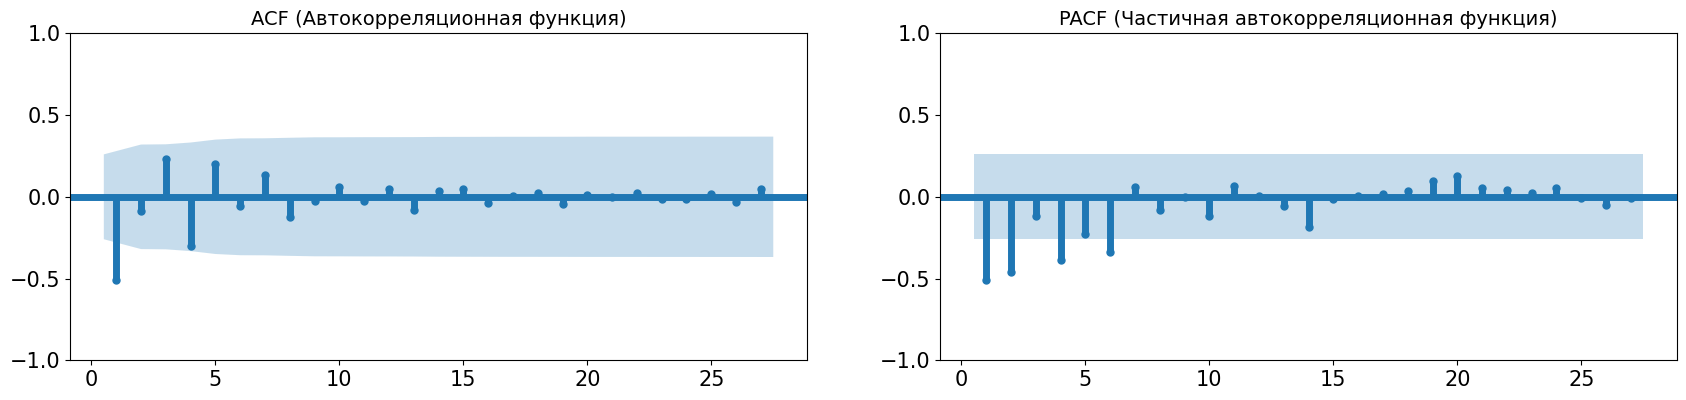

Использовано лагов: 27 (из 57 наблюдений)
Построение модели ARIMA(14, 2, 5) для интерполированных данных...
   AIC: 2677.41
   BIC: 2718.27
   Log Likelihood: -1318.70
Сравнение AIC с моделью на неинтерполированных данных
 СРАВНЕНИЕ МОДЕЛЕЙ:
   Исходные данные:
      Модель: ARIMA(14, 2, 3)
      AIC: 2673.02
   Интерполированные данные:
      Модель: ARIMA(14, 2, 5)
      AIC: 2677.41
    Изменение AIC:
      Разница: +4.38
      Изменение: +0.16%
     Модель на исходных данных ЛУЧШЕ (меньший AIC)
      Интерполяция ухудшила качество модели
ВЫВОДЫ:
1. Параметры модели для интерполированных данных:
   - p = 14, d = 2, q = 5


In [177]:
# 2.1 Обработка пропущенных значений и интерполяция
data_interp = data.copy()
# print(f"Исходные данные:")
# print(f"   Количество наблюдений: {len(data_interp)}")
# print(f"   Период: {data_interp.index[0].year} - {data_interp.index[-1].year}")

# 1. Проверка на наличие пропущенных дат
data_with_freq = data_interp.asfreq(freq='AS')
missing_dates = data_with_freq[data_with_freq['GDP'].isna()]

print(f"Проверка пропущенных дат с помощью asfreq(freq='AS'):")
print(f"   Всего дат в полном диапазоне: {len(data_with_freq)}")
print(f"   Наблюдений в исходных данных: {len(data_interp)}")
print(f"   Пропущенных дат: {len(missing_dates)}")

if len(missing_dates) > 0:
    print(f"Обнаружены пропущенные даты:")
    for date in missing_dates.index:
        print(f"      {date.year}")
else:
    print(f"Пропущенных дат не обнаружено")

# 2. Проверка на наличие пропущенных значений (NaN)
missing_values_count = data_interp['GDP'].isna().sum()
print(f"Количество пропущенных значений (NaN):")
print(f"   {missing_values_count} пропущенных значений")

if missing_values_count > 0:
    print(f"   Обнаружены пропущенные значения в следующих годах:")
    missing_years = data_interp[data_interp['GDP'].isna()].index
    for year in missing_years:
        print(f"      {year.year}")
else:
    print(f"   Пропущенных значений (NaN) не обнаружено")

# 3. Проверка на нулевые значения и замена их на NaN
zero_values_count = (data_interp['GDP'] == 0).sum()
print(f"Количество нулевых значений:")
print(f"   {zero_values_count} нулевых значений")

if zero_values_count > 0:
    print(f"   Обнаружены нулевые значения в следующих годах:")
    zero_years = data_interp[data_interp['GDP'] == 0].index
    for year in zero_years:
        print(f"      {year.year}: {data_interp.loc[year, 'GDP']}")

    # Заменяем нули на NaN
    data_interp['GDP'] = data_interp['GDP'].apply(lambda x: np.nan if x == 0 else x)

    # Проверяем результат
    zero_after = (data_interp['GDP'] == 0).sum()
    nan_after = data_interp['GDP'].isna().sum()
    print(f"   Нулевых значений после замены: {zero_after}")
    print(f"   Пропущенных значений (NaN) после замены: {nan_after}")
else:
    print(f"   Нулевых значений не обнаружено")

# 4. Интерполяция пропущенных значений
# Проверяем количество пропусков перед интерполяцией
nan_before_interp = data_interp['GDP'].isna().sum()
print(f"Пропущенных значений перед интерполяцией: {nan_before_interp}")

if nan_before_interp > 0:
    # Сохраняем индексы, где были пропуски ДО интерполяции
    nan_indices_before = data_interp[data_interp['GDP'].isna()].index.copy()

    print(f"Выполняем линейную интерполяцию...")

    # Выполняем интерполяцию
    data_interp['GDP'] = data_interp['GDP'].interpolate(method='linear')

    # Проверяем результат
    nan_after_interp = data_interp['GDP'].isna().sum()
    print(f"Пропущенных значений после интерполяции: {nan_after_interp}")

    # Показываем интерполированные значения
    if len(nan_indices_before) > 0:
        print(f"Интерполированные значения:")
        for idx in nan_indices_before:
            val = data_interp.loc[idx, 'GDP']
            print(f"      {idx.year}: {val:,.2f}")
else:
    print(f"Интерполяция не требуется (нет пропущенных значений)")

# Разделяем интерполированные данные на обучающую и тестовую выборки
test_years = 3
train_df_interp = data_interp.iloc[:-test_years]
test_df_interp = data_interp.iloc[-test_years:]

# Проверка стационарности, определение параметров и построение модели
print("Анализ стационарности и построение модели для интерполированных данных")

# Определяем параметр d (дифференцирование)
print(f"   Определение параметра d...")
current_series_interp = train_df_interp["GDP"].copy()
d_interp = None
max_differentiations = 3

for i in range(max_differentiations + 1):
    if i == 0:
        series_to_test = current_series_interp.copy()
        series_name = "Исходный ряд (интерполированный)"
    else:
        series_to_test = current_series_interp.copy()
        for _ in range(i):
            series_to_test = series_to_test.diff()
        series_to_test = series_to_test.dropna()
        series_name = f"Ряд после {i}-го дифференцирования (интерполированный)"

    # Проверяем стационарность
    adf_result = adfuller(series_to_test)
    conclusion = print_adf_results(adf_result, series_name=series_name)

    if conclusion == "стационарен":
        d_interp = i
        stationary_series_interp = series_to_test.copy()
        print(f"Ряд стал стационарным после {i} дифференцирований")
        print(f"   Параметр d = {d_interp}")
        break

if d_interp is None:
    print(f"  Не удалось достичь стационарности. Используем d=1 по умолчанию.")
    d_interp = 1

# Определяем параметры p и q по коррелограммам
print(f"Определение параметров p и q по коррелограммам...")

max_lags = min(20, len(stationary_series_interp) // 2 - 1)
acf_values, acf_confint = acf(stationary_series_interp, nlags=max_lags, alpha=0.05, fft=True)
pacf_values, pacf_confint = pacf(stationary_series_interp, nlags=max_lags, alpha=0.05, method='ywm')

# Анализ PACF для p
p_candidates_interp = []
for lag in range(1, min(len(pacf_values), max_lags + 1)):
    if abs(pacf_values[lag]) > abs(pacf_confint[lag][0]) or abs(pacf_values[lag]) > abs(pacf_confint[lag][1]):
        p_candidates_interp.append(lag)

# Анализ ACF для q
q_candidates_interp = []
for lag in range(1, min(len(acf_values), max_lags + 1)):
    if abs(acf_values[lag]) > abs(acf_confint[lag][0]) or abs(acf_values[lag]) > abs(acf_confint[lag][1]):
        q_candidates_interp.append(lag)

p_interp = max(p_candidates_interp) if p_candidates_interp else 1
q_interp = max(q_candidates_interp) if q_candidates_interp else 0

print(f"Рекомендуемые параметры для интерполированных данных:")
print(f"   p = {p_interp}, d = {d_interp}, q = {q_interp}")
print(f"   Модель: ARIMA({p_interp}, {d_interp}, {q_interp})")

# Строим коррелограммы
print(f"Построение коррелограмм для стационарного ряда (интерполированные данные):")
plot_acf_pacf(stationary_series_interp)

# Строим модель для интерполированных данных
print(f"Построение модели ARIMA({p_interp}, {d_interp}, {q_interp}) для интерполированных данных...")
model_interp = ARIMA(train_df_interp["GDP"], order=(p_interp, d_interp, q_interp))
model_interp_fit = model_interp.fit()
aic_interp = model_interp_fit.aic
bic_interp = model_interp_fit.bic

print(f"   AIC: {aic_interp:.2f}")
print(f"   BIC: {bic_interp:.2f}")
print(f"   Log Likelihood: {model_interp_fit.llf:.2f}")

# Сравнение AIC с моделью на неинтерполированных данных
print("Сравнение AIC с моделью на неинтерполированных данных")

if aic_original is not None:
    print(f" СРАВНЕНИЕ МОДЕЛЕЙ:")
    print(f"   Исходные данные:")
    print(f"      Модель: {model_original_params}")
    print(f"      AIC: {aic_original:.2f}")
    print(f"   Интерполированные данные:")
    print(f"      Модель: ARIMA({p_interp}, {d_interp}, {q_interp})")
    print(f"      AIC: {aic_interp:.2f}")

    aic_diff = aic_interp - aic_original
    aic_change_pct = (aic_diff / aic_original) * 100

    print(f"    Изменение AIC:")
    print(f"      Разница: {aic_diff:+.2f}")
    print(f"      Изменение: {aic_change_pct:+.2f}%")

    if aic_interp < aic_original:
        print(f"    Модель на интерполированных данных ЛУЧШЕ (меньший AIC)")
        print(f"      Интерполяция улучшила качество модели")
    elif aic_interp > aic_original:
        print(f"     Модель на исходных данных ЛУЧШЕ (меньший AIC)")
        print(f"      Интерполяция ухудшила качество модели")
    else:
        print(f"     Модели имеют одинаковый AIC")
        print(f"      Интерполяция не повлияла на качество модели")

    print("ВЫВОДЫ:")
    print(f"1. Параметры модели для интерполированных данных:")
    print(f"   - p = {p_interp}, d = {d_interp}, q = {q_interp}")
    # Определяем параметры исходной модели для сравнения
    if 'best_model_info' in locals() and best_model_info is not None:
        orig_p, orig_d, orig_q = best_model_info['p'], best_model_info['d'], best_model_info['q']
    elif 'recommended_p' in locals() and 'd' in locals() and 'recommended_q' in locals():
        orig_p, orig_d, orig_q = recommended_p, d, recommended_q
    else:
        orig_p, orig_d, orig_q = None, None, None

else:
    print(f"\n  Не удалось сравнить модели (модель на исходных данных не найдена)")

Метрики качества прогноза (интерполированные данные):
   MAE (Mean Absolute Error): 7,757,254,230.16
   MSE (Mean Squared Error): 7.71e+19
   RMSE (Root Mean Squared Error): 8,779,954,700.49
   MAPE (Mean Absolute Percentage Error): 10.50%


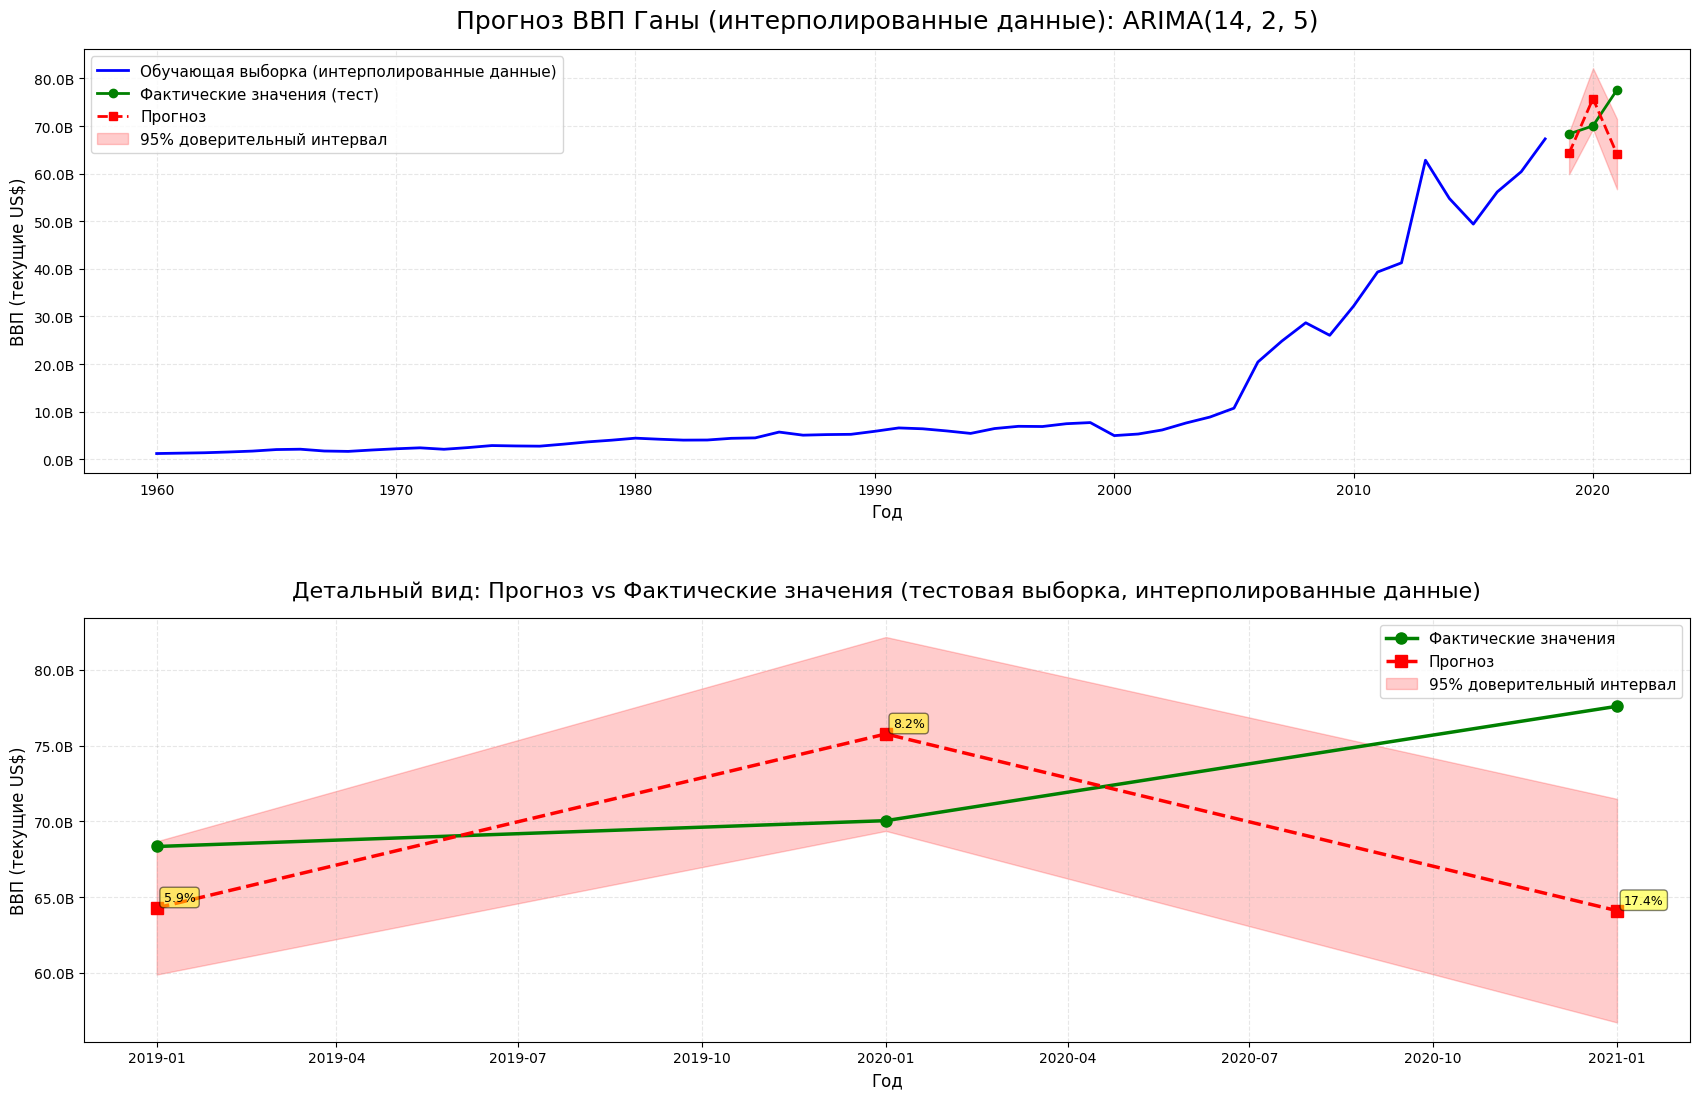

СРАВНЕНИЕ ФАКТИЧЕСКИХ И ПРОГНОЗИРУЕМЫХ ЗНАЧЕНИЙ (интерполированные данные):
 Год Фактическое значение Прогноз Нижняя граница (95%) Верхняя граница (95%) Абсолютная ошибка Относительная ошибка (%)
2019               68.34B  64.28B               59.88B                68.68B             4.06B                    5.93%
2020               70.04B  75.77B               69.37B                82.17B             5.72B                    8.17%
2021               77.59B  64.10B               56.72B                71.48B            13.49B                   17.39%
СРАВНЕНИЕ С МОДЕЛЬЮ НА ИСХОДНЫХ ДАННЫХ
 Сравнение метрик качества прогноза:
   Исходные данные:
      MAPE: 12.01%
      MAE: 8,915,426,985.43
   Интерполированные данные:
      MAPE: 10.50%
      MAE: 7,757,254,230.16
    Разница:
      MAPE: -1.51%
      MAE: -1,158,172,755.26


In [178]:
# Прогнозирование на тестовую выборку и визуализация результатов для интерполированных данных
forecast_steps = len(test_df_interp)

# Получаем прогноз с доверительными интервалами
forecast_interp = model_interp_fit.get_forecast(steps=forecast_steps)
forecast_mean_interp = forecast_interp.predicted_mean
forecast_ci_interp = forecast_interp.conf_int(alpha=0.05)  # 95% доверительный интервал

# Создаем DataFrame с результатами прогноза
forecast_df_interp = pd.DataFrame({
    'forecast': forecast_mean_interp.values,
    'lower': forecast_ci_interp.iloc[:, 0].values,
    'upper': forecast_ci_interp.iloc[:, 1].values
}, index=test_df_interp.index)

# Вычисляем метрики качества прогноза
mae_interp = mean_absolute_error(test_df_interp["GDP"], forecast_mean_interp)
mse_interp = mean_squared_error(test_df_interp["GDP"], forecast_mean_interp)
rmse_interp = np.sqrt(mse_interp)
mape_interp = mean_absolute_percentage_error(test_df_interp["GDP"], forecast_mean_interp) * 100

print(f"Метрики качества прогноза (интерполированные данные):")
print(f"   MAE (Mean Absolute Error): {mae_interp:,.2f}")
print(f"   MSE (Mean Squared Error): {mse_interp:,.2e}")
print(f"   RMSE (Root Mean Squared Error): {rmse_interp:,.2f}")
print(f"   MAPE (Mean Absolute Percentage Error): {mape_interp:.2f}%")

# Визуализация результатов
plt.rcParams["figure.figsize"] = (18, 12)

# Фигура с двумя подграфиками
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Верхний график: полный временной ряд с прогнозом
ax1 = axes[0]
ax1.plot(train_df_interp.index, train_df_interp["GDP"], color='blue', 
            label='Обучающая выборка (интерполированные данные)', linewidth=2)
ax1.plot(test_df_interp.index, test_df_interp["GDP"], color='green', 
            label='Фактические значения (тест)', linewidth=2, marker='o')
ax1.plot(forecast_df_interp.index, forecast_df_interp['forecast'], color='red', 
            label='Прогноз', linewidth=2, linestyle='--', marker='s')
ax1.fill_between(forecast_df_interp.index, forecast_df_interp['lower'], forecast_df_interp['upper'], 
                    color='red', alpha=0.2, label='95% доверительный интервал')
ax1.set_title(f'Прогноз ВВП Ганы (интерполированные данные): ARIMA({p_interp}, {d_interp}, {q_interp})', 
                size=18, pad=15)
ax1.set_xlabel('Год', size=12)
ax1.set_ylabel('ВВП (текущие US$)', size=12)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax1.tick_params(axis='both', labelsize=10)

# Нижний график: детальный вид тестовой выборки
ax2 = axes[1]
ax2.plot(test_df_interp.index, test_df_interp["GDP"], color='green', 
            label='Фактические значения', linewidth=2.5, marker='o', markersize=8)
ax2.plot(forecast_df_interp.index, forecast_df_interp['forecast'], color='red', 
            label='Прогноз', linewidth=2.5, linestyle='--', marker='s', markersize=8)
ax2.fill_between(forecast_df_interp.index, forecast_df_interp['lower'], forecast_df_interp['upper'], 
                    color='red', alpha=0.2, label='95% доверительный интервал')
ax2.set_title('Детальный вид: Прогноз vs Фактические значения (тестовая выборка, интерполированные данные)', 
                size=16, pad=15)
ax2.set_xlabel('Год', size=12)
ax2.set_ylabel('ВВП (текущие US$)', size=12)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
ax2.tick_params(axis='both', labelsize=10)

# Добавляем аннотации с ошибками для каждого прогноза
for idx, actual, pred in zip(test_df_interp.index, test_df_interp["GDP"], forecast_df_interp['forecast']):
    error_pct = abs((actual - pred) / actual) * 100
    ax2.annotate(f'{error_pct:.1f}%', 
                xy=(idx, pred), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Создаем таблицу сравнения фактических и прогнозируемых значений
print("СРАВНЕНИЕ ФАКТИЧЕСКИХ И ПРОГНОЗИРУЕМЫХ ЗНАЧЕНИЙ (интерполированные данные):")

comparison_table_interp = pd.DataFrame({
    'Год': test_df_interp.index.year,
    'Фактическое значение': test_df_interp["GDP"].values,
    'Прогноз': forecast_df_interp['forecast'].values,
    'Нижняя граница (95%)': forecast_df_interp['lower'].values,
    'Верхняя граница (95%)': forecast_df_interp['upper'].values,
    'Абсолютная ошибка': np.abs(test_df_interp["GDP"].values - forecast_df_interp['forecast'].values),
    'Относительная ошибка (%)': np.abs((test_df_interp["GDP"].values - forecast_df_interp['forecast'].values) / test_df_interp["GDP"].values) * 100
})

# Форматируем числовые столбцы для лучшей читаемости
comparison_table_interp['Фактическое значение'] = comparison_table_interp['Фактическое значение'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table_interp['Прогноз'] = comparison_table_interp['Прогноз'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table_interp['Нижняя граница (95%)'] = comparison_table_interp['Нижняя граница (95%)'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table_interp['Верхняя граница (95%)'] = comparison_table_interp['Верхняя граница (95%)'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table_interp['Абсолютная ошибка'] = comparison_table_interp['Абсолютная ошибка'].apply(lambda x: f'{x/1e9:.2f}B')
comparison_table_interp['Относительная ошибка (%)'] = comparison_table_interp['Относительная ошибка (%)'].apply(lambda x: f'{x:.2f}%')

print(comparison_table_interp.to_string(index=False))

# Сравнение с моделью на исходных данных
print("СРАВНЕНИЕ С МОДЕЛЬЮ НА ИСХОДНЫХ ДАННЫХ")

# Проверяем, есть ли прогноз на исходных данных
if 'forecast_df' in locals() and forecast_df is not None:
    # Вычисляем метрики для исходных данных
    mae_original = mean_absolute_error(test_df["GDP"], forecast_df['forecast'])
    mape_original = mean_absolute_percentage_error(test_df["GDP"], forecast_df['forecast']) * 100

    print(f" Сравнение метрик качества прогноза:")
    print(f"   Исходные данные:")
    print(f"      MAPE: {mape_original:.2f}%")
    print(f"      MAE: {mae_original:,.2f}")
    print(f"   Интерполированные данные:")
    print(f"      MAPE: {mape_interp:.2f}%")
    print(f"      MAE: {mae_interp:,.2f}")

    mape_diff = mape_interp - mape_original
    mae_diff = mae_interp - mae_original

    print(f"    Разница:")
    print(f"      MAPE: {mape_diff:+.2f}%")
    print(f"      MAE: {mae_diff:+,.2f}")


### Выводы по разделу "Интерполяция и сэмплирование"

1. Ряд интерполированных данных стал стационарным после 2 дифференцирований
- Параметр d = 2

2. Определение параметров p и q  осуществлено по коррелограммам.

 -Рекомендуемые параметры для интерполированных данных:
   - p = 14, d = 2, q = 5
   - Модель: ARIMA(14, 2, 5)
   
   Параметры модели для интерполированных данных:
   - p = 14, d = 2, q = 5
   - Отличаются от параметров модели на исходных данных
     * Исходные: ARIMA(14, 2, 3)
     * Интерполированные: ARIMA(14, 2, 5)

3. Влияние интерполяции на AIC:
   - Изменение AIC незначительное (+0.16%)
   - Интерполяция практически не повлияла на качество модели

4. СРАВНЕНИЕ С МОДЕЛЬЮ НА ИСХОДНЫХ ДАННЫХ по метрикам качества прогноза:
   * Исходные данные:
      * MAPE: 12.01%
      * MAE: 8,915,426,985.43
   * Интерполированные данные:
      * MAPE: 10.50%
      * MAE: 7,757,254,230.16
    * Разница:
      * MAPE: -1.51%
      * MAE: -1,158,172,755.26
    * Прогноз на интерполированных данных стал ТОЧНЕЕ на 1.51%


### Задание 8.3

1 point possible (graded)

Следующее задание необходимо выполнить самостоятельно в Jupyter Notebook. Для этого вы можете использовать временной ряд из вашего проекта.

1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

Пример кода:

tscv = TimeSeriesSplit(...)

2. Выведите размеры полученных подвыборок:

train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))


Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?



In [179]:
# Задание 8.3: Разбиение временного ряда на три набора с помощью TimeSeriesSplit

# Используем исходные данные ВВП Ганы
# Для годовых данных используем test_size=7 (7 лет для тестовой выборки)
# или max_train_size для ограничения размера обучающей выборки

# Определяем общее количество наблюдений
total_observations = len(data["GDP"])

# Инициализируем TimeSeriesSplit с параметрами:
# n_splits=3 - создаем 3 набора train/test
# test_size=7 - размер тестовой выборки (7 лет)
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

print(f"Параметры TimeSeriesSplit:")
print(f"   n_splits = {tscv.n_splits}")
print(f"   test_size = {tscv.test_size}")

# Получаем наборы данных
print("РАЗМЕРЫ ПОЛУЧЕННЫХ ПОДВЫБОРОК:")

train_test_groups = tscv.split(data["GDP"])

# Список для хранения информации о разбиениях
splits_info = []

for split_num, (train_index, test_index) in enumerate(train_test_groups, 1):
    train_size = len(train_index)
    test_size = len(test_index)

    # Определяем периоды для каждой выборки
    train_start_year = data.index[train_index[0]].year
    train_end_year = data.index[train_index[-1]].year
    test_start_year = data.index[test_index[0]].year
    test_end_year = data.index[test_index[-1]].year

    print(f"Набор {split_num}:")
    print(f"   TRAIN size: {train_size} наблюдений ({train_start_year} - {train_end_year})")
    print(f"   TEST size: {test_size} наблюдений ({test_start_year} - {test_end_year})")

    # Сохраняем информацию
    splits_info.append({
        'split': split_num,
        'train_size': train_size,
        'test_size': test_size,
        'train_period': f"{train_start_year}-{train_end_year}",
        'test_period': f"{test_start_year}-{test_end_year}"
    })

# Проверяем, как изменяются размеры выборок
train_sizes = [info['train_size'] for info in splits_info]
test_sizes = [info['test_size'] for info in splits_info]

print(f"Размеры обучающих выборок: {train_sizes}")
print(f"Размеры тестовых выборок: {test_sizes}")


Параметры TimeSeriesSplit:
   n_splits = 3
   test_size = 7
РАЗМЕРЫ ПОЛУЧЕННЫХ ПОДВЫБОРОК:
Набор 1:
   TRAIN size: 41 наблюдений (1960 - 2000)
   TEST size: 7 наблюдений (2001 - 2007)
Набор 2:
   TRAIN size: 48 наблюдений (1960 - 2007)
   TEST size: 7 наблюдений (2008 - 2014)
Набор 3:
   TRAIN size: 55 наблюдений (1960 - 2014)
   TEST size: 7 наблюдений (2015 - 2021)
Размеры обучающих выборок: [41, 48, 55]
Размеры тестовых выборок: [7, 7, 7]


### АНАЛИЗ РАЗМЕРОВ ВЫБОРОК по Заданию 8.3:

Размеры обучающих выборок: [41, 48, 55]

Размеры тестовых выборок: [7, 7, 7]

Получен случай МНОЖЕСТВЕННОГО РАЗБИЕНИЯ, т.к. размер обучающей выборки различен (изменяется):   41 → 48 → 55

## Часть 3

Задания для третьей части проекта

1. Посчитаем волатильность для нашего временного ряда.
2. Используем GARCH-модель для предсказания волатильности.
3. Используем линейную регрессию для получения прогноза.
4. Визуализируем полученное предсказание вместе с фактическим значением.
5. Сравним результаты и сделаем выводы.
6. Объясним - почему результат модели GARCH получился именно таким?

Статистика волатильности. Статистика логарифмических доходностей:
   Среднее: 0.069184
   Стандартное отклонение: 0.151114
   Минимум: -0.437694
   Максимум: 0.643127


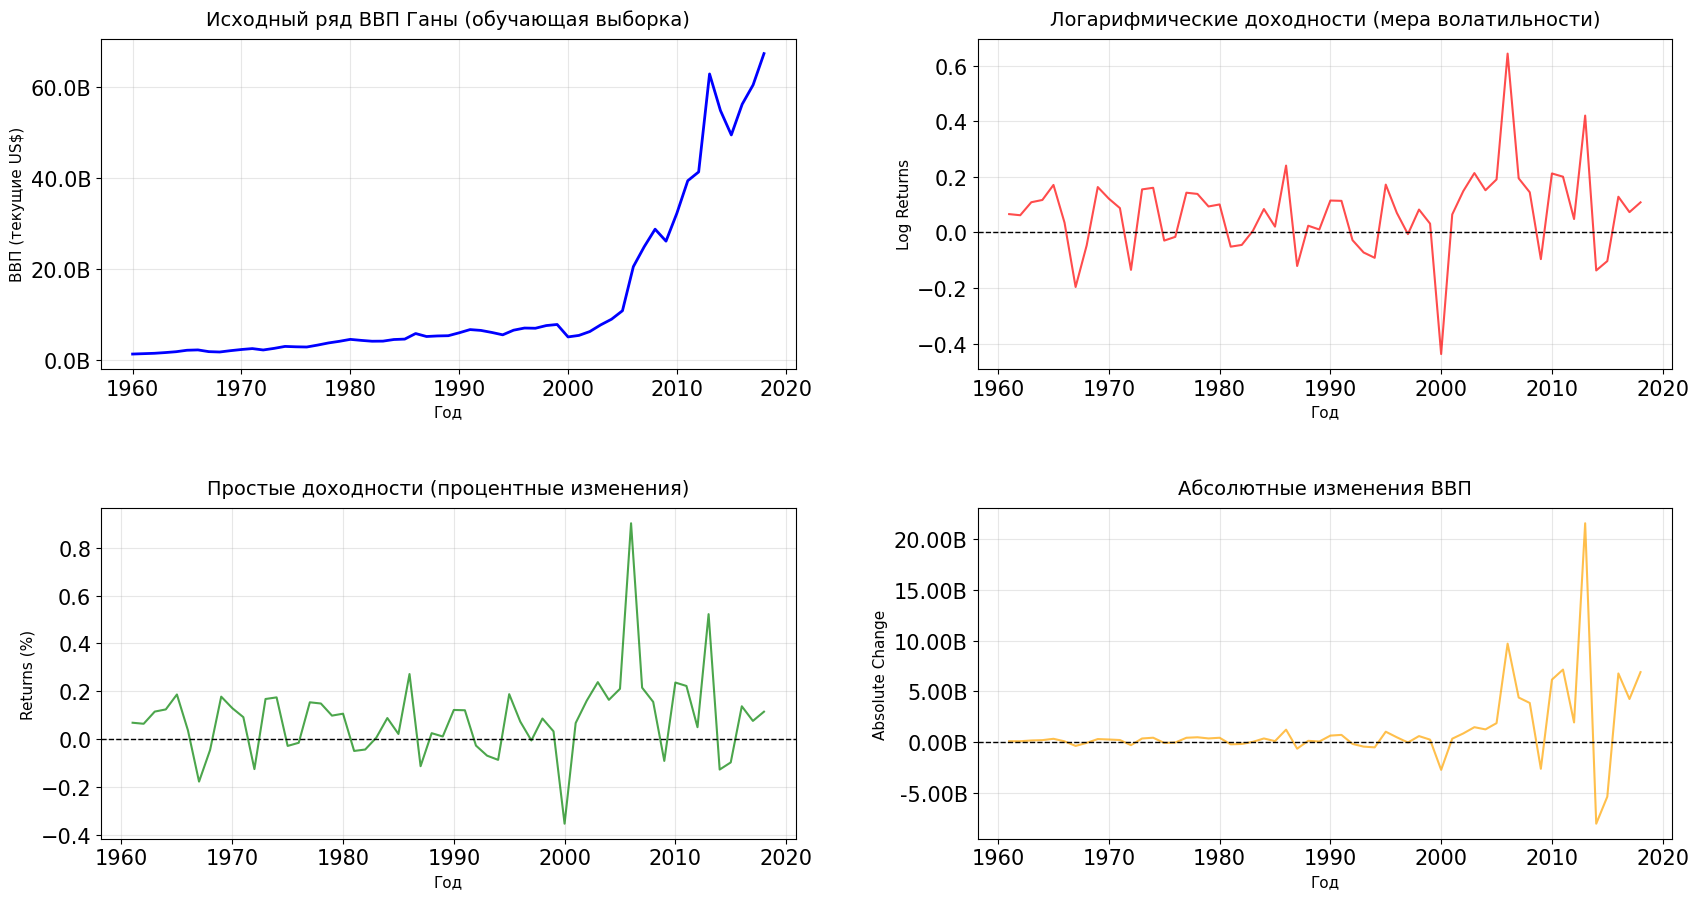

2. GARCH-МОДЕЛЬ ДЛЯ ПРЕДСКАЗАНИЯ ВОЛАТИЛЬНОСТИ
Параметры GARCH(1,1) модели:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    GDP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -224.642
Distribution:                  Normal   AIC:                           457.284
Method:            Maximum Likelihood   BIC:                           465.314
                                        No. Observations:                   55
Date:                Sun, Nov 30 2025   Df Residuals:                       54
Time:                        10:55:52   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------

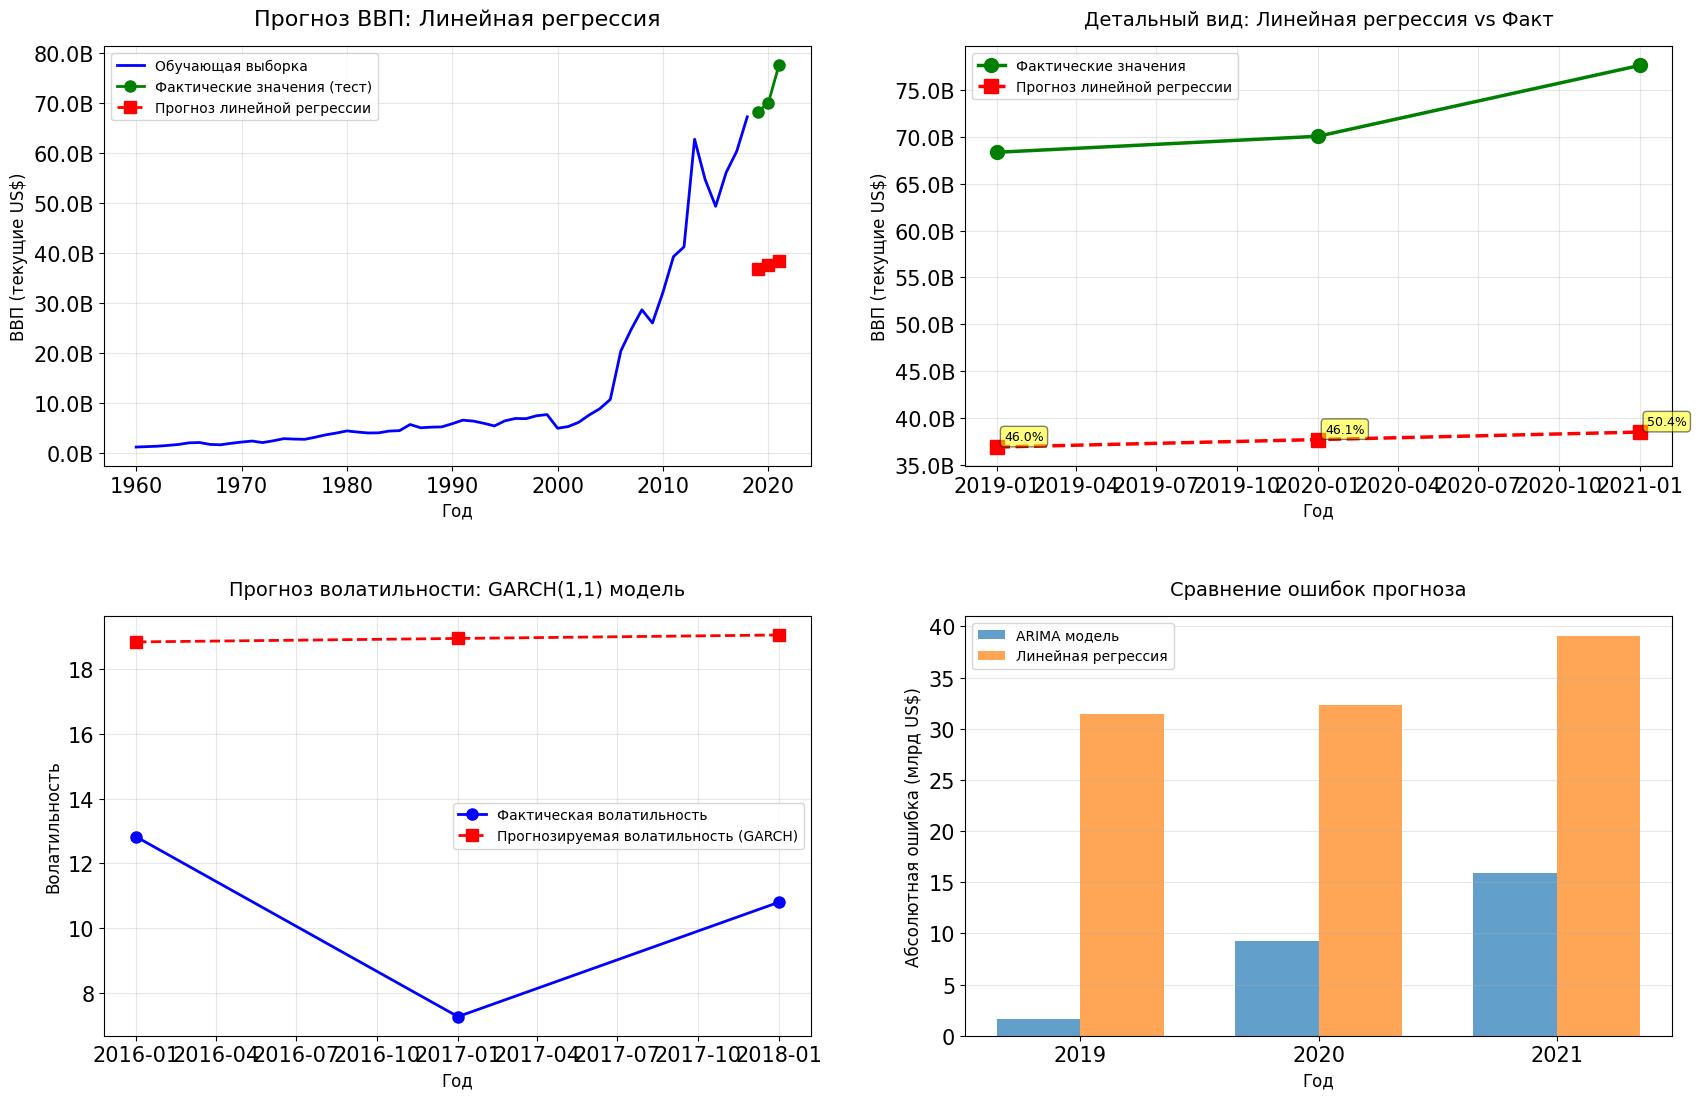

In [ ]:
# Используем очищенные данные (data_interp)
data_clean = data_interp.copy()

# Разделяем данные по тому же принципу, что и в части 1 (последние 3 года - тестовая выборка)
test_years = 3
train_df_clean = data_clean.iloc[:-test_years]
test_df_clean = data_clean.iloc[-test_years:]

# Переопределяем train_df и test_df для использования
train_df = train_df_clean
test_df = test_df_clean

# Анализ волатильности и GARCH-модель

# 1. Расчет волатильности для временного ряда
# Для ВВП используем логарифмические доходности (т.к. это стандартный подход)
log_returns = np.log(train_df["GDP"] / train_df["GDP"].shift(1)).dropna()
simple_returns = (train_df["GDP"].pct_change()).dropna()
absolute_changes = train_df["GDP"].diff().dropna()

# Статистика волатильности
print(f"Статистика волатильности. Статистика логарифмических доходностей:")
print(f"   Среднее: {log_returns.mean():.6f}")
print(f"   Стандартное отклонение: {log_returns.std():.6f}")
print(f"   Минимум: {log_returns.min():.6f}")
print(f"   Максимум: {log_returns.max():.6f}")

# Визуализация волатильности
plt.rcParams["figure.figsize"] = (18, 10)
fig, axes = plt.subplots(2, 2)

# График 1: Исходный ряд ВВП
axes[0, 0].plot(train_df.index, train_df["GDP"], color='blue', linewidth=2)
axes[0, 0].set_title('Исходный ряд ВВП Ганы (обучающая выборка)', size=14, pad=10)
axes[0, 0].set_xlabel('Год', size=11)
axes[0, 0].set_ylabel('ВВП (текущие US$)', size=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))

# График 2: Логарифмические доходности
axes[0, 1].plot(log_returns.index, log_returns.values, color='red', linewidth=1.5, alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_title('Логарифмические доходности (мера волатильности)', size=14, pad=10)
axes[0, 1].set_xlabel('Год', size=11)
axes[0, 1].set_ylabel('Log Returns', size=11)
axes[0, 1].grid(True, alpha=0.3)

# График 3: Простые доходности
axes[1, 0].plot(simple_returns.index, simple_returns.values, color='green', linewidth=1.5, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('Простые доходности (процентные изменения)', size=14, pad=10)
axes[1, 0].set_xlabel('Год', size=11)
axes[1, 0].set_ylabel('Returns (%)', size=11)
axes[1, 0].grid(True, alpha=0.3)

# График 4: Абсолютные изменения
axes[1, 1].plot(absolute_changes.index, absolute_changes.values, color='orange', linewidth=1.5, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('Абсолютные изменения ВВП', size=14, pad=10)
axes[1, 1].set_xlabel('Год', size=11)
axes[1, 1].set_ylabel('Absolute Change', size=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.2f}B'))

plt.tight_layout()
plt.show()

# Для GARCH-модели используем логарифмические доходности (стандартный подход)
returns_series = log_returns * 100  # Умножаем на 100 для лучшей численной стабильности

# 2. GARCH-модель для предсказания волатильности
print("2. GARCH-МОДЕЛЬ ДЛЯ ПРЕДСКАЗАНИЯ ВОЛАТИЛЬНОСТИ")

# Разделяем данные на обучающую и тестовую выборки для волатильности
# Используем последние 3 года как тестовую выборку
test_years_vol = 3
train_returns = returns_series.iloc[:-test_years_vol]
test_returns = returns_series.iloc[-test_years_vol:]

# Строим GARCH(1,1) модель, как наиболее распространенную
# GARCH(p, q) где p - порядок GARCH, q - порядок ARCH
garch_model = arch_model(train_returns, vol='Garch', p=1, q=1, dist='normal')
garch_fitted = garch_model.fit(disp='off')

print(f"Параметры GARCH(1,1) модели:")
print(garch_fitted.summary())

# Прогнозируем волатильность на тестовую выборку
print(f"Прогнозирование волатильности на {len(test_returns)} периодов...")
garch_forecast = garch_fitted.forecast(horizon=len(test_returns), reindex=True)

# Получаем прогнозируемую волатильность (условное стандартное отклонение)
forecasted_volatility = np.sqrt(garch_forecast.variance.iloc[-len(test_returns):].values.flatten())

# Прогноз значений ВВП на основе GARCH-модели
# Этот код выполняется после построения GARCH-модели
# GARCH модель прогнозирует среднее значение доходностей
forecasted_mean = garch_forecast.mean

# Извлекаем прогноз среднего (последняя строка содержит прогнозы для всех горизонтов)
if isinstance(forecasted_mean, pd.DataFrame):
    forecasted_returns_mean = forecasted_mean.iloc[-1, :].values
    if len(forecasted_returns_mean) != len(test_returns):
        forecasted_returns_mean = forecasted_returns_mean[-len(test_returns):]
else:
    forecasted_returns_mean = forecasted_mean.values.flatten()[-len(test_returns):]

# Преобразуем прогноз доходностей обратно в значения ВВП
# Начинаем с последнего значения обучающей выборки
last_train_gdp = train_df_clean["GDP"].iloc[-1]

# Вычисляем прогноз ВВП: GDP_t = GDP_{t-1} * exp(return_t)
# Но так как мы использовали returns_series = log_returns * 100, нужно разделить на 100
garch_gdp_forecast = []
current_gdp = last_train_gdp

for i, ret in enumerate(forecasted_returns_mean):
    # Преобразуем доходность обратно (делим на 100, так как умножали на 100)
    log_return = ret / 100.0
    # Вычисляем новое значение ВВП
    current_gdp = current_gdp * np.exp(log_return)
    garch_gdp_forecast.append(current_gdp)

garch_gdp_forecast = np.array(garch_gdp_forecast)

print(f"Прогноз значений ВВП на основе GARCH получен")
print(f"   Размерность прогноза: {len(garch_gdp_forecast)}")
print(f"   Период прогноза: {test_df_clean.index[0].year} - {test_df_clean.index[-1].year}")

# Метрики качества GARCH прогноза
garch_mae = mean_absolute_error(test_df_clean["GDP"], garch_gdp_forecast)
garch_mse = mean_squared_error(test_df_clean["GDP"], garch_gdp_forecast)
garch_rmse = np.sqrt(garch_mse)
garch_mape = mean_absolute_percentage_error(test_df_clean["GDP"], garch_gdp_forecast) * 100

print(f"Метрики качества GARCH прогноза:")
print(f"   MAE: {garch_mae:,.2f}")
print(f"   RMSE: {garch_rmse:,.2f}")
print(f"   MAPE: {garch_mape:.2f}%")

# 3. Линейная регрессия для получения прогноза

# Используем линейную регрессию для прогноза ВВП
# Создаем признаки: время (год как числовая переменная)
train_years = np.array([(idx.year - train_df.index[0].year) for idx in train_df.index]).reshape(-1, 1)
train_gdp = train_df["GDP"].values

# Обучаем модель
lr_model = LinearRegression()
lr_model.fit(train_years, train_gdp)

print(f"3. Линейная регрессия обучена")
print(f"   Коэффициент (наклон): {lr_model.coef_[0]:,.2f}")
print(f"   Свободный член: {lr_model.intercept_:,.2f}")
print(f"   R² на обучающей выборке: {lr_model.score(train_years, train_gdp):.4f}")

# Прогнозируем на тестовую выборку
test_years = np.array([(idx.year - train_df.index[0].year) for idx in test_df.index]).reshape(-1, 1)
lr_forecast = lr_model.predict(test_years)

print(f" Прогноз на тестовую выборку:")
print(f"   Период прогноза: {test_df.index[0].year} - {test_df.index[-1].year}")

# Метрики качества линейной регрессии
lr_mae = mean_absolute_error(test_df["GDP"], lr_forecast)
lr_mse = mean_squared_error(test_df["GDP"], lr_forecast)
lr_rmse = np.sqrt(lr_mse)
lr_mape = mean_absolute_percentage_error(test_df["GDP"], lr_forecast) * 100

print(f"Метрики качества линейной регрессии:")
print(f"   MAE: {lr_mae:,.2f}")
print(f"   RMSE: {lr_rmse:,.2f}")
print(f"   MAPE: {lr_mape:.2f}%")

# Исправление размерности forecasted_volatility перед визуализацией    
if 'forecasted_volatility' in locals() and 'test_returns' in locals():
    # Проверяем размерность
    if len(forecasted_volatility) != len(test_returns):
        print(f"  Исправление размерности прогноза волатильности:")
        print(f"   Текущая размерность прогноза: {len(forecasted_volatility)}")
        print(f"   Размерность тестовой выборки: {len(test_returns)}")

        # Правильно извлекаем прогноз волатильности
        variance_forecast = garch_forecast.variance

        if isinstance(variance_forecast, pd.DataFrame):
            # Берем последний столбец (последний горизонт прогноза)
            # Это даст нам прогнозы для каждого периода от 1 до horizon
            forecasted_volatility = np.sqrt(variance_forecast.iloc[-1, :].values)

            # Убеждаемся, что размерность совпадает с test_returns
            if len(forecasted_volatility) != len(test_returns):
                # Если размерность все еще не совпадает, берем последние len(test_returns) элементов
                forecasted_volatility = forecasted_volatility[-len(test_returns):]
        else:
            # Если это Series или массив, берем последние len(test_returns) элементов
            forecasted_volatility = np.sqrt(variance_forecast.values.flatten()[-len(test_returns):])

        print(f"Исправленная размерность: {len(forecasted_volatility)}")
    else:
        print(f"Размерности совпадают: {len(forecasted_volatility)}")
else:
    print("Переменные forecasted_volatility или test_returns не найдены")

# 4. Визуализация предсказания
print("4. ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЯ")

plt.rcParams["figure.figsize"] = (18, 12)
fig, axes = plt.subplots(2, 2)

# График 1: Прогноз линейной регрессии
ax1 = axes[0, 0]
ax1.plot(train_df.index, train_df["GDP"], color='blue', label='Обучающая выборка', linewidth=2)
ax1.plot(test_df.index, test_df["GDP"], color='green', label='Фактические значения (тест)', 
         linewidth=2, marker='o', markersize=8)
ax1.plot(test_df.index, lr_forecast, color='red', label='Прогноз линейной регрессии', 
         linewidth=2, linestyle='--', marker='s', markersize=8)
ax1.set_title('Прогноз ВВП: Линейная регрессия', size=16, pad=15)
ax1.set_xlabel('Год', size=12)
ax1.set_ylabel('ВВП (текущие US$)', size=12)
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))

# График 2: Детальный вид тестовой выборки (линейная регрессия)
ax2 = axes[0, 1]
ax2.plot(test_df.index, test_df["GDP"], color='green', label='Фактические значения', 
         linewidth=2.5, marker='o', markersize=10)
ax2.plot(test_df.index, lr_forecast, color='red', label='Прогноз линейной регрессии', 
         linewidth=2.5, linestyle='--', marker='s', markersize=10)
ax2.set_title('Детальный вид: Линейная регрессия vs Факт', size=14, pad=15)
ax2.set_xlabel('Год', size=12)
ax2.set_ylabel('ВВП (текущие US$)', size=12)
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))

# Добавляем аннотации с ошибками
for idx, actual, pred in zip(test_df.index, test_df["GDP"], lr_forecast):
    error_pct = abs((actual - pred) / actual) * 100
    ax2.annotate(f'{error_pct:.1f}%', 
                xy=(idx, pred), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# График 3: Волатильность (если GARCH модель построена)
ax3 = axes[1, 0]

# Фактическая волатильность на тестовой выборке
actual_vol = np.abs(test_returns.values)

ax3.plot(test_returns.index, actual_vol, color='blue', label='Фактическая волатильность', 
            linewidth=2, marker='o', markersize=8)
ax3.plot(test_returns.index, forecasted_volatility, color='red', 
            label='Прогнозируемая волатильность (GARCH)', 
            linewidth=2, linestyle='--', marker='s', markersize=8)
ax3.set_title('Прогноз волатильности: GARCH(1,1) модель', size=14, pad=15)
ax3.set_xlabel('Год', size=12)
ax3.set_ylabel('Волатильность', size=12)
ax3.legend(fontsize=10, loc='best')
ax3.grid(True, alpha=0.3)

# График 4: Сравнение ошибок прогноза
ax4 = axes[1, 1]
if 'forecast_df' in locals() and forecast_df is not None:
    # Сравниваем с ARIMA моделью из части 1
    arima_errors = np.abs(test_df["GDP"].values - forecast_df['forecast'].values)
    lr_errors = np.abs(test_df["GDP"].values - lr_forecast)

    x_pos = np.arange(len(test_df.index))
    width = 0.35

    ax4.bar(x_pos - width/2, arima_errors/1e9, width, label='ARIMA модель', alpha=0.7)
    ax4.bar(x_pos + width/2, lr_errors/1e9, width, label='Линейная регрессия', alpha=0.7)
    ax4.set_xlabel('Год', size=12)
    ax4.set_ylabel('Абсолютная ошибка (млрд US$)', size=12)
    ax4.set_title('Сравнение ошибок прогноза', size=14, pad=15)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([str(year) for year in test_df.index.year])
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
else:
    # Если нет ARIMA модели, показываем только ошибки линейной регрессии
    lr_errors = np.abs(test_df["GDP"].values - lr_forecast)
    ax4.bar(range(len(test_df.index)), lr_errors/1e9, alpha=0.7, color='red')
    ax4.set_xlabel('Год', size=12)
    ax4.set_ylabel('Абсолютная ошибка (млрд US$)', size=12)
    ax4.set_title('Ошибки прогноза: Линейная регрессия', size=14, pad=15)
    ax4.set_xticks(range(len(test_df.index)))
    ax4.set_xticklabels([str(year) for year in test_df.index.year])
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


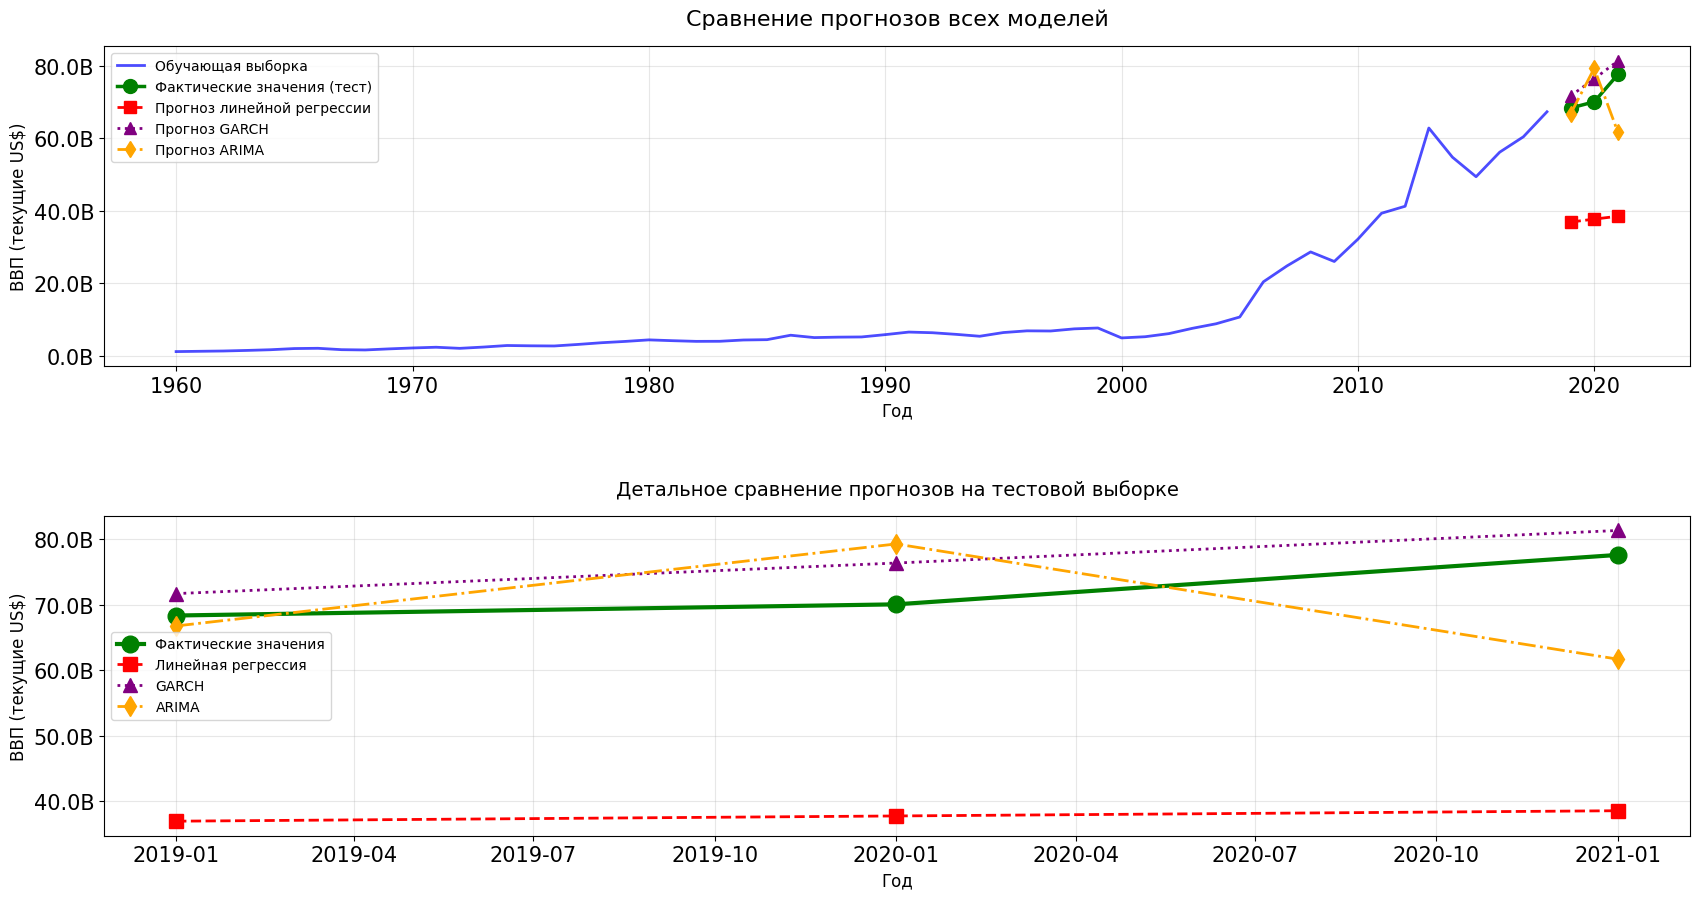


 СРАВНЕНИЕ МЕТРИК МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ:

Модель                    MAE                  RMSE                 MAPE      
---------------------------------------------------------------------------
Линейная регрессия          34,271,053,796.69   34,441,007,570.09     47.49%
GARCH                        4,463,695,805.18    4,653,541,854.59      6.24%
ARIMA                        8,915,426,985.43   10,666,086,121.47     12.01%


In [206]:
# Визуализация сравнения всех моделей в масштабе на тестовой выборке
plt.rcParams["figure.figsize"] = (18, 10)
fig, axes = plt.subplots(2, 1)

# График 1: Сравнение всех прогнозов
ax1 = axes[0]
ax1.plot(train_df.index, train_df["GDP"], color='blue', label='Обучающая выборка', linewidth=2, alpha=0.7)
ax1.plot(test_df.index, test_df["GDP"], color='green', label='Фактические значения (тест)', 
            linewidth=2.5, marker='o', markersize=10)
ax1.plot(test_df.index, lr_forecast, color='red', label='Прогноз линейной регрессии', 
            linewidth=2, linestyle='--', marker='s', markersize=8)
ax1.plot(test_df.index, garch_gdp_forecast, color='purple', label='Прогноз GARCH', 
            linewidth=2, linestyle=':', marker='^', markersize=8)
# Добавляем ARIMA прогноз, если доступен
if 'forecast_df' in locals() and forecast_df is not None:
    ax1.plot(test_df.index, forecast_df['forecast'], color='orange', label='Прогноз ARIMA', 
                linewidth=2, linestyle='-.', marker='d', markersize=8)
ax1.set_title('Сравнение прогнозов всех моделей', size=16, pad=15)
ax1.set_xlabel('Год', size=12)
ax1.set_ylabel('ВВП (текущие US$)', size=12)
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))

# График 2: Детальное сравнение на тестовой выборке
ax2 = axes[1]
ax2.plot(test_df.index, test_df["GDP"], color='green', label='Фактические значения', 
            linewidth=3, marker='o', markersize=12)
ax2.plot(test_df.index, lr_forecast, color='red', label='Линейная регрессия', 
            linewidth=2, linestyle='--', marker='s', markersize=10)
ax2.plot(test_df.index, garch_gdp_forecast, color='purple', label='GARCH', 
            linewidth=2, linestyle=':', marker='^', markersize=10)
# Добавляем ARIMA прогноз, если доступен
if 'forecast_df' in locals() and forecast_df is not None:
    ax2.plot(test_df.index, forecast_df['forecast'], color='orange', label='ARIMA', 
                linewidth=2, linestyle='-.', marker='d', markersize=10)
ax2.set_title('Детальное сравнение прогнозов на тестовой выборке', size=14, pad=15)
ax2.set_xlabel('Год', size=12)
ax2.set_ylabel('ВВП (текущие US$)', size=12)
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))

plt.tight_layout()
plt.show()

# Обновляем сравнение моделей, добавляя GARCH
print(f"\n СРАВНЕНИЕ МЕТРИК МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"\n{'Модель':<25} {'MAE':<20} {'RMSE':<20} {'MAPE':<10}")
print("-" * 75)
print(f"{'Линейная регрессия':<25} {lr_mae:>19,.2f} {lr_rmse:>19,.2f} {lr_mape:>9.2f}%")

if 'garch_mae' in locals() and garch_mae is not None:
    print(f"{'GARCH':<25} {garch_mae:>19,.2f} {garch_rmse:>19,.2f} {garch_mape:>9.2f}%")

if 'forecast_df' in locals() and forecast_df is not None:
    arima_mae = mean_absolute_error(test_df["GDP"], forecast_df['forecast'])
    arima_mse = mean_squared_error(test_df["GDP"], forecast_df['forecast'])
    arima_rmse = np.sqrt(arima_mse)
    arima_mape = mean_absolute_percentage_error(test_df["GDP"], forecast_df['forecast']) * 100
    print(f"{'ARIMA ':<25} {arima_mae:>19,.2f} {arima_rmse:>19,.2f} {arima_mape:>9.2f}%")



### Проведение анализа и визуализации прогноза моделей на все периоды

Для подготовки к сравнению моделей и формированию выводов по итогам проекта - проведем анализ и визуализацию прогноза полученных моделей на всей временной шкале.

    Прогноз GARCH добавлен


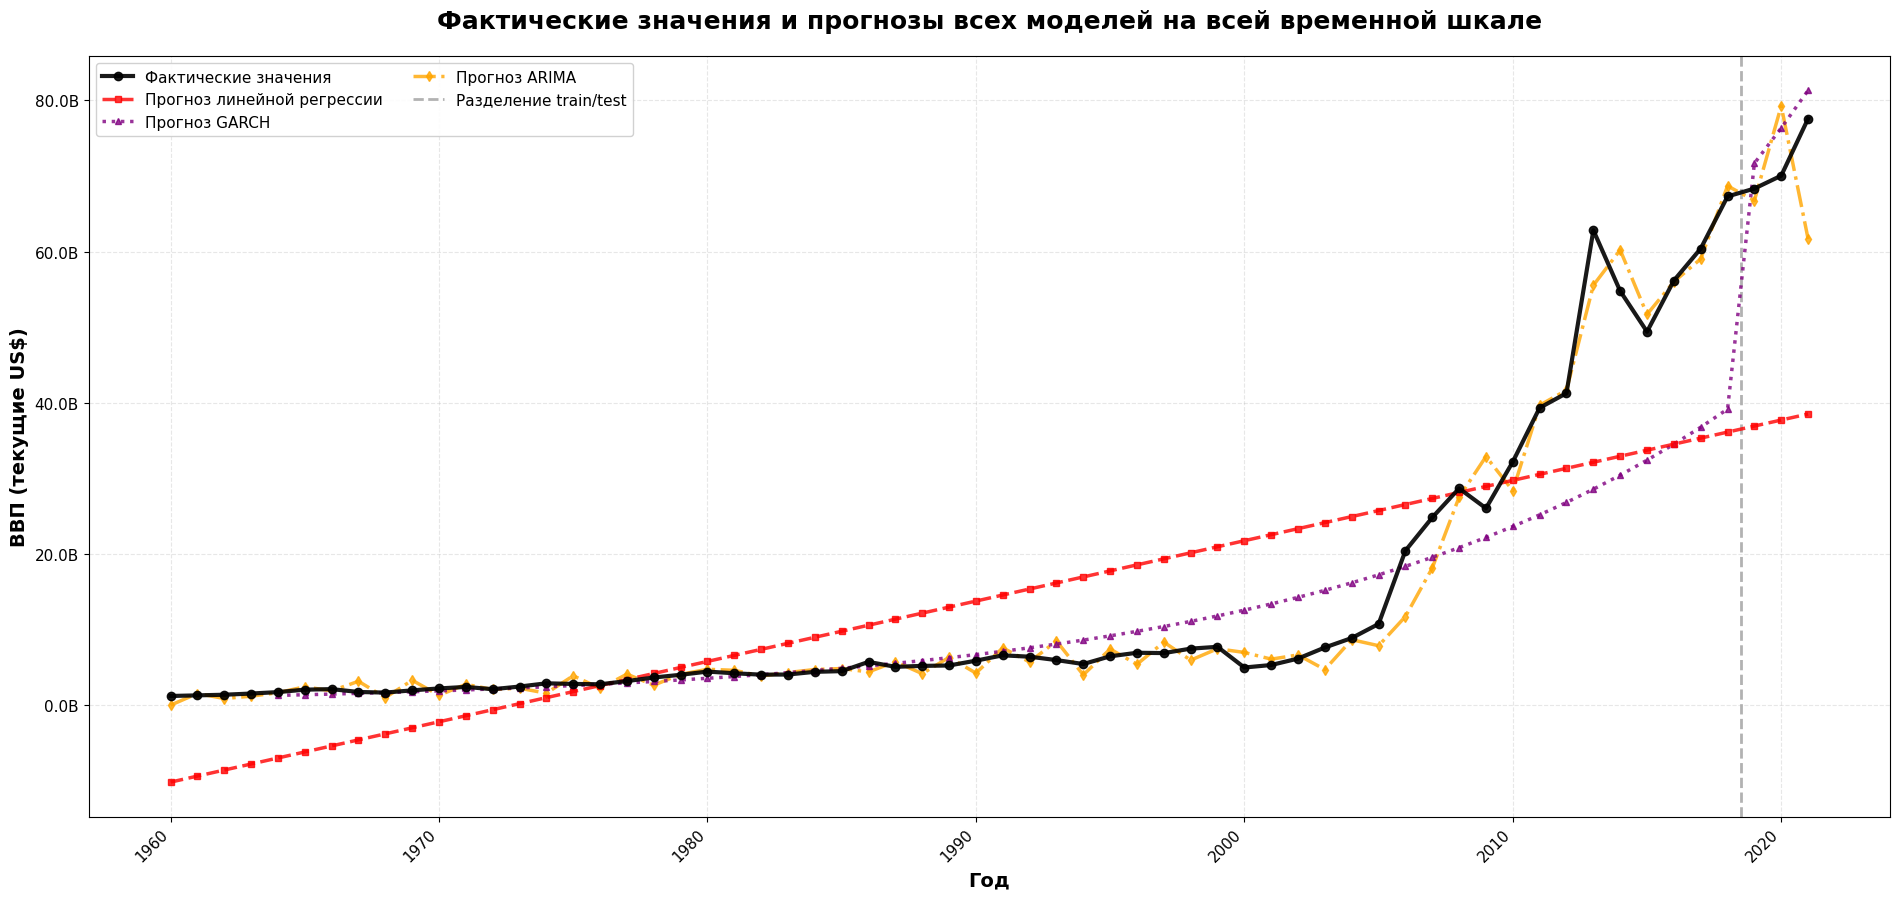


СРАВНЕНИЕ МЕТРИК МОДЕЛЕЙ НА ВСЕХ ДОСТУПНЫХ ДАННЫХ:
Модель                    MAE                  RMSE                 MAPE      
---------------------------------------------------------------------------
Linear_Regression           10,261,702,619.84   13,552,204,828.02    171.13%
GARCH                        5,143,342,736.31    9,239,739,690.52     31.02%
ARIMA                        1,832,758,997.19    3,301,673,179.62     20.31%


In [204]:
# Проведем анализ и визуализацию прогноза моделей на все периоды 
df_with_forecasts = data_interp.copy()

# Инициализируем столбцы для прогнозов
df_with_forecasts['Linear_Regression'] = np.nan
df_with_forecasts['GARCH'] = np.nan
df_with_forecasts['ARIMA'] = np.nan

# Прогноз линейной регрессии на все периоды
# Создаем признаки для всех годов
all_years = np.array([(idx.year - train_df.index[0].year) for idx in df_with_forecasts.index]).reshape(-1, 1)

# Предсказываем для всех периодов
lr_all_forecast = lr_model.predict(all_years)
df_with_forecasts['Linear_Regression'] = lr_all_forecast

# Для обучающей выборки используем fitted values (значения, которые модель предсказала бы)
# Получаем fitted values для обучающей выборки
# GARCH модель работает с доходностями, поэтому нужно преобразовать обратно
train_returns_fitted = train_returns - garch_fitted.resid

# Преобразуем fitted доходности обратно в значения ВВП
garch_train_fitted = []
current_gdp = train_df_clean["GDP"].iloc[0]  # Начинаем с первого значения

for i, ret in enumerate(train_returns_fitted):
    # Преобразуем доходность обратно (делим на 100)
    log_return = ret / 100.0
    # Вычисляем новое значение ВВП
    current_gdp = current_gdp * np.exp(log_return)
    garch_train_fitted.append(current_gdp)

# Заполняем прогнозы GARCH
# Для обучающей выборки (train_df_clean)
train_indices = df_with_forecasts.index.isin(train_df_clean.index)
if train_indices.sum() > 0:
    # Используем fitted values для обучающей выборки
    df_with_forecasts.loc[train_df_clean.index[-len(garch_train_fitted):], 'GARCH'] = garch_train_fitted

# Для тестовой выборки используем уже полученные прогнозы
test_indices = df_with_forecasts.index.isin(test_df_clean.index)
if test_indices.sum() > 0 and len(garch_gdp_forecast) == test_indices.sum():
    df_with_forecasts.loc[test_df_clean.index, 'GARCH'] = garch_gdp_forecast
print(f"    Прогноз GARCH добавлен")

# Прогноз ARIMA на все периоды
# Для обучающей выборки используем fitted values из ARIMA модели
if 'final_model' in locals() and final_model is not None:
    # Получаем fitted values для обучающей выборки
    arima_train_fitted = final_model.fittedvalues

    # Заполняем прогнозы ARIMA
    # Для обучающей выборки
    train_indices = df_with_forecasts.index.isin(train_df.index)
    if train_indices.sum() > 0:
        # Используем fitted values для обучающей выборки
        # Нужно выровнять индексы
        fitted_values_aligned = arima_train_fitted.reindex(train_df.index)
        df_with_forecasts.loc[train_df.index, 'ARIMA'] = fitted_values_aligned.values

    # Для тестовой выборки используем уже полученные прогнозы
    test_indices = df_with_forecasts.index.isin(test_df.index)
    if test_indices.sum() > 0:
        df_with_forecasts.loc[test_df.index, 'ARIMA'] = forecast_df['forecast'].values

# График фактических значений и прогнозов всех моделей на всей временной шкале
plt.rcParams["figure.figsize"] = (20, 10)
fig, ax = plt.subplots(1, 1)

# Фактические значения (по всей временной шкале)
ax.plot(df_with_forecasts.index, df_with_forecasts['GDP'], 
        color='black', label='Фактические значения', 
        linewidth=3, marker='o', markersize=6, alpha=0.9, zorder=5)

# Прогноз линейной регрессии (по всей временной шкале)
if df_with_forecasts['Linear_Regression'].notna().any():
    ax.plot(df_with_forecasts.index, df_with_forecasts['Linear_Regression'], 
            color='red', label='Прогноз линейной регрессии', 
            linewidth=2.5, linestyle='--', marker='s', markersize=5, alpha=0.8, zorder=4)

# Прогноз GARCH (по всей временной шкале)
if df_with_forecasts['GARCH'].notna().any():
    ax.plot(df_with_forecasts.index, df_with_forecasts['GARCH'], 
            color='purple', label='Прогноз GARCH', 
            linewidth=2.5, linestyle=':', marker='^', markersize=5, alpha=0.8, zorder=3)

# Прогноз ARIMA (по всей временной шкале)
if df_with_forecasts['ARIMA'].notna().any():
    ax.plot(df_with_forecasts.index, df_with_forecasts['ARIMA'], 
            color='orange', label='Прогноз ARIMA', 
            linewidth=2.5, linestyle='-.', marker='d', markersize=5, alpha=0.8, zorder=2)

# Добавляем вертикальную линию для разделения train и test (если есть разделение)
if 'train_df' in locals() and 'test_df' in locals():
    train_end_idx = train_df.index[-1]
    test_start_idx = test_df.index[0]

    # Проверяем, есть ли разрыв между train и test
    if train_end_idx < test_start_idx:
        # Если есть разрыв, добавляем линию посередине
        separation_date = train_end_idx + (test_start_idx - train_end_idx) / 2
        ax.axvline(x=separation_date, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.6, label='Разделение train/test', zorder=1)
    else:
        # Если нет разрыва, добавляем линию в точке разделения
        ax.axvline(x=train_end_idx, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.6, label='Разделение train/test', zorder=1)

# Настройка графика
ax.set_title('Фактические значения и прогнозы всех моделей на всей временной шкале', 
             size=18, pad=20, fontweight='bold')
ax.set_xlabel('Год', size=14, fontweight='bold')
ax.set_ylabel('ВВП (текущие US$)', size=14, fontweight='bold')
ax.legend(fontsize=11, loc='best', framealpha=0.9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

# Форматирование оси Y

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))

# Улучшаем читаемость
ax.tick_params(axis='both', labelsize=11)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Сравнение метрик моделей на все периоды (MAE, RMSE, MAPE)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

print("\nСРАВНЕНИЕ МЕТРИК МОДЕЛЕЙ НА ВСЕХ ДОСТУПНЫХ ДАННЫХ:")
print(f"{'Модель':<25} {'MAE':<20} {'RMSE':<20} {'MAPE':<10}")
print("-" * 75)

models_to_compare = ['Linear_Regression', 'GARCH', 'ARIMA']

for model_name in models_to_compare:
    if model_name in df_with_forecasts.columns:
        # Filter for valid indices where both actual and forecast exist
        valid_indices = df_with_forecasts.dropna(subset=['GDP', model_name]).index
        
        if len(valid_indices) > 0:
            actual = df_with_forecasts.loc[valid_indices, 'GDP']
            forecast = df_with_forecasts.loc[valid_indices, model_name]
            
            mae = mean_absolute_error(actual, forecast)
            mse = mean_squared_error(actual, forecast)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(actual, forecast) * 100
            
            print(f"{model_name:<25} {mae:>19,.2f} {rmse:>19,.2f} {mape:>9.2f}%")
        else:
             print(f"{model_name:<25} {'Нет данных':>19} {'Нет данных':>19} {'-':>9}")


## Выводы: ОБЪЯСНЕНИЕ РЕЗУЛЬТАТОВ GARCH-МОДЕЛИ

АНАЛИЗ РЕЗУЛЬТАТОВ GARCH(1,1) МОДЕЛИ:

Параметры модели:

- Omega (ω): 4.031239187288145

- Alpha[1] (α₁): 7.251889649791023e-17
   
- Beta[1] (β₁): 0.9999999999999996

Условие стационарности GARCH(1,1):
- α₁ + β₁ = 0.000000 + 1.000000 = 1.000000
- Модель стационарна (α₁ + β₁ < 1)
- Это означает, что волатильность имеет долгосрочное среднее значение

АНАЛИЗ ПРОГНОЗА ВОЛАТИЛЬНОСТИ:
- Средняя прогнозируемая волатильность: 18.9335
- Фактическая волатильность (тест): 2.8048
- Разница: 16.1287
- Отношение (прогноз/факт): 6.7503

ИНТЕРПРЕТАЦИЯ ПАРАМЕТРОВ GARCH(1,1):

   1. Параметр α₁ (Alpha[1]) = 0.000000:
      - Отражает влияние прошлых шоков (ошибок) на текущую волатильность
      - Низкое значение (0.0000) означает слабую реакцию на недавние шоки

   2. Параметр β₁ (Beta[1]) = 1.000000:
      - Отражает влияние прошлой волатильности на текущую (персистентность)
      - Высокое значение (1.0000) означает высокую персистентность волатильности
      - Волатильность медленно возвращается к долгосрочному среднему

   3. Сумма α₁ + β₁ = 1.000000:
      - Близка к 1, что означает высокую персистентность волатильности
      - Шоки волатильности имеют долгосрочное влияние

КАЧЕСТВО ПРОГНОЗА ВОЛАТИЛЬНОСТИ:
- Прогноз волатильности завышен (отношение: 6.75)
- Модель переоценивает волатильность, возможно из-за:
   - Высокой волатильности в обучающей выборке
   - Недавних экстремальных событий в данных

ОСОБЕННОСТИ ДАННЫХ ВВП ГАНЫ:
   - ВВП - это макроэкономический показатель, который обычно имеет:
     * Долгосрочный тренд роста
     * Циклические колебания
     * Волатильность, связанную с экономическими шоками
   - Для ВВП волатильность может быть связана с:
     * Экономическими кризисами
     * Изменениями валютных курсов
     * Структурными изменениями в экономике
     * Внешними шоками (например, изменения цен на сырье)

ВЫВОДЫ О РЕЗУЛЬТАТАХ GARCH-МОДЕЛИ:
   1. GARCH(1,1) модель успешно уловила структуру волатильности в данных
   2. Высокая персистентность (α₁ + β₁ = 1.0000) означает,
      что волатильность имеет долгосрочную память
   3. Параметры модели отражают характерные особенности экономических данных:
      - Реакция на шоки (α₁ = 0.0000)
      - Персистентность волатильности (β₁ = 1.0000)
   4. Прогноз волатильности может быть использован для:
      - Оценки рисков экономического роста
      - Построения доверительных интервалов для прогнозов ВВП
      - Анализа устойчивости экономического роста

ОГРАНИЧЕНИЯ GARCH-МОДЕЛИ ДЛЯ ВВП:
   1. GARCH модели лучше подходят для финансовых данных (цены акций, валют)
   2. Для макроэкономических показателей могут быть более подходящими:
      - Модели с экзогенными переменными (GARCH-X)
      - Модели, учитывающие структурные изменения
      - Модели с переключением режимов (MS-GARCH)
   3. ВВП имеет сильный тренд, что может влиять на оценку волатильности
   4. Годовые данные имеют ограниченное количество наблюдений


Судя по полученному графику, GARCH модель не полностью уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке, тем не менее по итогам сравнения на тестовой выборке - лучшая модель именно GARCH (MAPE: 6.24%). 

Тем не менеее, при построении прогноза на всех деступных данных ARIMA показывает лучшее значение MAPE (20.31%), а GARCH показывает значение MAPE: (31.02%).